# Libraries & Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load Data

In [2]:
# gervasio file_path
file_path = r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"

In [ ]:
# shruti


In [ ]:
# fin

## Preliminary Data Processing for Control & Intervention

In [24]:
import pandas as pd
import os

# -----------------------------------------------------------------------------
# Step 0.1: Distinct date ranges for Pre and Post
# -----------------------------------------------------------------------------
pre_start = pd.Timestamp("2023-02-01 00:00:00")
pre_end   = pd.Timestamp("2024-01-31 23:59:59")

post_start = pd.Timestamp("2024-04-01 00:00:00")
post_end   = pd.Timestamp("2024-12-31 23:59:59")

def preprocess_and_aggregate(file_name, start_date, end_date):
    df = pd.read_csv(os.path.join(file_path, file_name))
    df = df.rename(columns={'Unnamed: 0': 'Time'})
    
    # Convert Time column to datetime
    df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S")

    print(f"Processing {file_name} -> Min Time: {df['Time'].min()}, Max Time: {df['Time'].max()}")

    # Filter by time range (pre or post)
    df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]

    # Keep only 4-7 PM consumption
    df = df[(df['Time'].dt.hour >= 16) & (df['Time'].dt.hour < 19)]

    # Convert from wide to long format
    df_long = df.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')

    # Remove duplicates after melting
    df_long.drop_duplicates(subset=['Time', 'ANON_ID'], inplace=True)

    # Aggregate by ANON_ID (mean consumption from 4–7pm)
    df_agg = df_long.groupby('ANON_ID', as_index=False)['ELEC_KWH'].mean()

    return df_agg

# -----------------------------------------------------------------------------
# Process each file for the correct date range
# -----------------------------------------------------------------------------

# CONTROL: We assume:
#   controlePreConsolide.csv => belongs to the Pre period
#   controleConsolide.csv => belongs to the Post period (Mon–Sat)
#   controleConsolideSunday.csv => also belongs to the Post period, but specifically Sunday
# You can adapt as needed if your real data has different date spans.

df_control_pre        = preprocess_and_aggregate("controlePreConsolide.csv", pre_start, pre_end)
df_control_post       = preprocess_and_aggregate("controleConsolide.csv",    post_start, post_end)
df_control_sunday     = preprocess_and_aggregate("controleConsolideSunday.csv", post_start, post_end)

print("Shapes =>",
      "\nControl Pre:", df_control_pre.shape,
      "\nControl Post:", df_control_post.shape,
      "\nControl Sunday:", df_control_sunday.shape)

# INTERVENTION
df_intervention_pre   = preprocess_and_aggregate("interventionPreConsolide.csv", pre_start, pre_end)
df_intervention_post  = preprocess_and_aggregate("interventionConsolide.csv",    post_start, post_end)
df_intervention_sunday = preprocess_and_aggregate("interventionConsolideSunday.csv", post_start, post_end)

print("Shapes =>",
      "\nIntervention Pre:", df_intervention_pre.shape,
      "\nIntervention Post:", df_intervention_post.shape,
      "\nIntervention Sunday:", df_intervention_sunday.shape)


Processing controlePreConsolide.csv -> Min Time: 2023-02-02 00:00:00, Max Time: 2024-01-31 23:30:00
Processing controleConsolide.csv -> Min Time: 2024-04-01 00:00:00, Max Time: 2024-12-31 23:30:00
Processing controleConsolideSunday.csv -> Min Time: 2024-04-07 00:00:00, Max Time: 2024-12-29 23:30:00
Shapes => 
Control Pre: (320, 2) 
Control Post: (506, 2) 
Control Sunday: (503, 2)
Processing interventionPreConsolide.csv -> Min Time: 2023-02-02 00:00:00, Max Time: 2024-01-31 23:30:00
Processing interventionConsolide.csv -> Min Time: 2024-04-01 00:00:00, Max Time: 2024-12-31 23:30:00
Processing interventionConsolideSunday.csv -> Min Time: 2024-04-07 00:00:00, Max Time: 2024-12-29 23:30:00
Shapes => 
Intervention Pre: (387, 2) 
Intervention Post: (666, 2) 
Intervention Sunday: (663, 2)


329, 2)

## Read & Merge Socio-Economic Data

In [5]:
# Step 0.2 (unchanged)
import pandas as pd
import os

socio_file = "socioEcodata.csv"
socio_df = pd.read_csv(os.path.join(file_path, socio_file))

# Drop unneeded columns
cols_to_drop = [
    'ESTIMATED_CONSUMPTION_ELEC_DAY',
    'ESTIMATED_CONSUMPTION_ELEC_NIGHT',
    'ESTIMATED_CONSUMPTION_TOTAL'
]
socio_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Rename HASH_KEY -> ANON_ID
if 'HASH_KEY' in socio_df.columns:
    socio_df.rename(columns={'HASH_KEY': 'ANON_ID'}, inplace=True)

# Drop rows where any feature is missing (NaN)
socio_df.dropna(inplace=True)

# Remove 'Unknown'
features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP', 'HOME_VALUE'
]
mask_no_unknown = (socio_df[features] != 'Unknown').all(axis=1)
socio_df = socio_df[mask_no_unknown].copy()

print(f"Socio-economic data shape after cleaning: {socio_df.shape}")

# Convert columns with a logical order into ordered categories
age_group_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
income_category_order = [
    '0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', 
    '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+'
]
household_occupancy_order = ['Single Adult Household', 'Couple Household', 'Multi-Occupancy Household']
children_at_home_order = ['0', '1', '2+']
household_size_order = ['1', '2', '3-4', '5+']
number_of_bedrooms_order = ['1', '2', '3', '4', '5+']
highest_qualification_order = [
    'GCSE Equivalent', 'A Level Equivalent', 
    'Secondary Education or Less', 'University Degree or Higher'
]
home_value_order = ['0-100k', '100-150k', '150-250k', '250-500k', '500k+']
social_grade_order = ['Social grade A', 'Social grade B', 'Social grade C1', 'Social grade C2', 'Social grade D']

feature_orders = {
    'AGE_GROUP': age_group_order,
    'INCOME_CATEGORY': income_category_order,
    'HOUSEHOLD_OCCUPANCY': household_occupancy_order,
    'CHILDREN_AT_HOME': children_at_home_order,
    'HOUSEHOLD_SIZE': household_size_order,
    'NUMBER_OF_BEDROOMS': number_of_bedrooms_order,
    'HIGHEST_QUALIFICATION': highest_qualification_order,
    'HOME_VALUE': home_value_order,
    'SOCIAL_GRADE': social_grade_order
}
for col, cat_order in feature_orders.items():
    if col in socio_df.columns:
        socio_df[col] = pd.Categorical(socio_df[col], categories=cat_order, ordered=True)


Socio-economic data shape after cleaning: (1044, 15)


## Merge Each Subset & Label Them

In [6]:
# Step 1: Merge & Label

df_control_pre_merged = pd.merge(df_control_pre, socio_df, on='ANON_ID', how='inner')
df_control_pre_merged['Group'] = 'Control'
df_control_pre_merged['Phase'] = 'Pre'

df_control_post_merged = pd.merge(df_control_post, socio_df, on='ANON_ID', how='inner')
df_control_post_merged['Group'] = 'Control'
df_control_post_merged['Phase'] = 'Post'

df_control_sunday_merged = pd.merge(df_control_sunday, socio_df, on='ANON_ID', how='inner')
df_control_sunday_merged['Group'] = 'Control'
df_control_sunday_merged['Phase'] = 'Sunday'


df_intervention_pre_merged = pd.merge(df_intervention_pre, socio_df, on='ANON_ID', how='inner')
df_intervention_pre_merged['Group'] = 'Intervention'
df_intervention_pre_merged['Phase'] = 'Pre'

df_intervention_post_merged = pd.merge(df_intervention_post, socio_df, on='ANON_ID', how='inner')
df_intervention_post_merged['Group'] = 'Intervention'
df_intervention_post_merged['Phase'] = 'Post'

df_intervention_sunday_merged = pd.merge(df_intervention_sunday, socio_df, on='ANON_ID', how='inner')
df_intervention_sunday_merged['Group'] = 'Intervention'
df_intervention_sunday_merged['Phase'] = 'Sunday'


print("Control Pre Merged:", df_control_pre_merged.shape)
print("Control Post Merged:", df_control_post_merged.shape)
print("Control Sunday Merged:", df_control_sunday_merged.shape)
print("Intervention Pre Merged:", df_intervention_pre_merged.shape)
print("Intervention Post Merged:", df_intervention_post_merged.shape)
print("Intervention Sunday Merged:", df_intervention_sunday_merged.shape)


Control Pre Merged: (286, 18)
Control Post Merged: (445, 18)
Control Sunday Merged: (445, 18)
Intervention Pre Merged: (343, 18)
Intervention Post Merged: (592, 18)
Intervention Sunday Merged: (591, 18)


## Pre-Post Comparisons

In [7]:
import numpy as np

# Combine only Pre and Post (exclude Sunday for the "shift" analysis)
df_combined_pre_post = pd.concat([
    df_control_pre_merged,
    df_control_post_merged,
    df_intervention_pre_merged,
    df_intervention_post_merged
], ignore_index=True)

# Group by ANON_ID, Group, Phase => get mean consumption
df_mean = (df_combined_pre_post
           .groupby(['ANON_ID','Group','Phase'], as_index=False)
           .agg(mean_kwh=('ELEC_KWH','mean')))

# Pivot so Pre, Post columns
df_pivot = df_mean.pivot(
    index=['ANON_ID','Group'],
    columns='Phase',
    values='mean_kwh'
).reset_index()

df_pivot['Reduction_%'] = ((df_pivot['Pre'] - df_pivot['Post']) / df_pivot['Pre']) * 100

# (Optional) Bracket assignment for Intervention
def bracket_assign(x):
    if pd.isna(x) or x < 5:
        return 'No Reward (< 5%)'
    elif x < 20:
        return 'Free Sun 8am-12pm (5-19.9%)'
    elif x < 35:
        return 'Free Sun 8am-4pm (20-34.9%)'
    elif x < 50:
        return 'Free Sun 8am-8pm (35-49.9%)'
    else:
        return 'Free Sun 8am-midnight (>=50%)'

df_pivot['Free_Energy_Bracket'] = np.where(
    df_pivot['Group'] == 'Intervention',
    df_pivot['Reduction_%'].apply(bracket_assign),
    'Not Applicable'
)

# Inspect final results
df_pivot.groupby('Group')['Reduction_%'].describe()


,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,286.0,2.989691,21.111384,-120.422813,-4.381601,3.950899,14.056459,67.389872
Intervention,342.0,5.704356,25.272131,-198.620586,-4.249022,8.571329,18.493226,82.039628


## Visual Representation

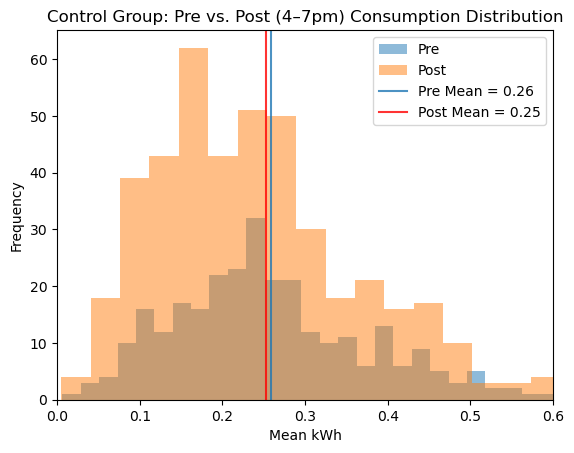

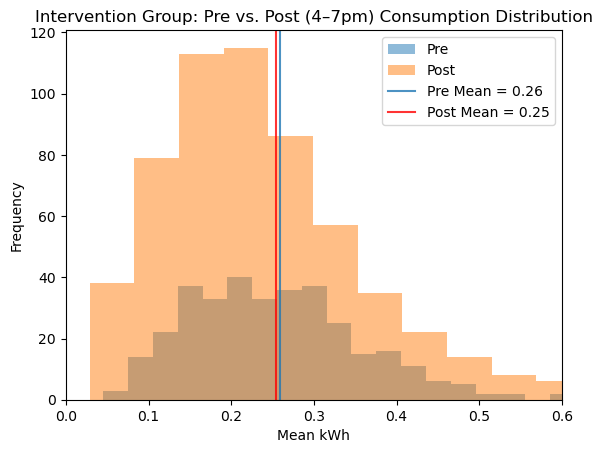

In [8]:
import matplotlib.pyplot as plt

# Suppose df_control and df_intervention each have 'Pre' and 'Post' columns
# created by pivoting your data. Something like:
df_control = df_pivot[df_pivot['Group'] == 'Control']
df_intervention = df_pivot[df_pivot['Group'] == 'Intervention']

# Calculate means
control_pre_mean = df_control['Pre'].mean()
control_post_mean = df_control['Post'].mean()
intervention_pre_mean = df_intervention['Pre'].mean()
intervention_post_mean = df_intervention['Post'].mean()

# -------------------------------------------------------------------------
# 1) CONTROL GROUP: Overlaid Histograms + Mean Lines
# -------------------------------------------------------------------------
plt.figure()

# Histograms
plt.hist(df_control['Pre'].dropna(), bins=30, alpha=0.5, label='Pre')
plt.hist(df_control['Post'].dropna(), bins=30, alpha=0.5, label='Post')

# Vertical lines for means
plt.axvline(x=control_pre_mean, alpha=0.8, label=f"Pre Mean = {control_pre_mean:.2f}")
plt.axvline(x=control_post_mean,  color ='red', alpha=0.8, label=f"Post Mean = {control_post_mean:.2f}")

plt.xlim(0, 0.6)
plt.title("Control Group: Pre vs. Post (4–7pm) Consumption Distribution")
plt.xlabel("Mean kWh")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# -------------------------------------------------------------------------
# 2) INTERVENTION GROUP: Overlaid Histograms + Mean Lines
# -------------------------------------------------------------------------
plt.figure()

# Histograms
plt.hist(df_intervention['Pre'].dropna(), bins=30, alpha=0.5, label='Pre')
plt.hist(df_intervention['Post'].dropna(), bins=30, alpha=0.5, label='Post')

# Vertical lines for means
plt.axvline(x=intervention_pre_mean, alpha=0.8, label=f"Pre Mean = {intervention_pre_mean:.2f}")
plt.axvline(x=intervention_post_mean,  color ='red', alpha=0.8, label=f"Post Mean = {intervention_post_mean:.2f}")

plt.xlim(0, 0.6)
plt.title("Intervention Group: Pre vs. Post (4–7pm) Consumption Distribution")
plt.xlabel("Mean kWh")
plt.ylabel("Frequency")
plt.legend()
plt.show()


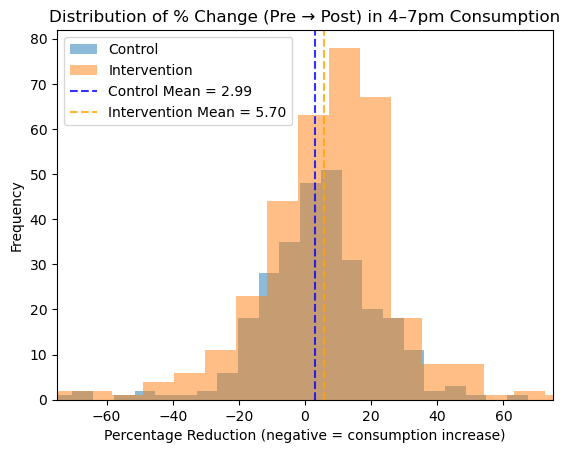

In [9]:
import matplotlib.pyplot as plt

# 1. Subset the data by group
df_control = df_pivot[df_pivot['Group'] == 'Control']
df_intervention = df_pivot[df_pivot['Group'] == 'Intervention']

# 2. Compute the means
control_mean = df_control['Reduction_%'].mean()
intervention_mean = df_intervention['Reduction_%'].mean()

plt.figure()

# 3. Plot the histograms in one chart
plt.hist(df_control['Reduction_%'].dropna(), bins=30, alpha=0.5, label='Control')
plt.hist(df_intervention['Reduction_%'].dropna(), bins=30, alpha=0.5, label='Intervention')

# 4. Add vertical lines at the mean values
plt.axvline(x=control_mean, color='blue', alpha=0.8, linestyle='--', label=f"Control Mean = {control_mean:.2f}")
plt.axvline(x=intervention_mean, color='orange', alpha=0.8, linestyle='--', label=f"Intervention Mean = {intervention_mean:.2f}")

# 5. (Optional) set x-limits based on your data range


plt.title("Distribution of % Change (Pre → Post) in 4–7pm Consumption")
plt.xlabel("Percentage Reduction (negative = consumption increase)")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(-75, 75)
plt.show()


## Statistical Testing
Two sample test

In [19]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

df_control = df_pivot[df_pivot['Group'] == 'Control'].dropna(subset=['Reduction_%'])
df_intervention = df_pivot[df_pivot['Group'] == 'Intervention'].dropna(subset=['Reduction_%'])

control_reduction = df_control['Reduction_%']
intervention_reduction = df_intervention['Reduction_%']

# 1) Welch's t-test (doesn't assume equal variances)
t_stat, p_value = ttest_ind(
    control_reduction, 
    intervention_reduction, 
    equal_var=False
)
print(f"Welch t-test => t={t_stat:.3f}, p={p_value:.5f}")

# 2) Mann–Whitney U (non-parametric)
u_stat, mw_p_value = mannwhitneyu(
    control_reduction, 
    intervention_reduction, 
    alternative='two-sided'
)
print(f"Mann-Whitney => U={u_stat:.3f}, p={mw_p_value:.5f}")


Welch t-test => t=-1.467, p=0.14297
Mann-Whitney => U=43124.000, p=0.01067


### Results:
If the data are not normal or have heavy outliers, a standard t-test might be misleading.

A “household with extremely low Pre consumption” can produce large percentage swings, which might distort the average.

## Difference-in-Differences (DiD) Approach

In [12]:
df_for_did = df_mean[['ANON_ID','Group','Phase','mean_kwh']].copy()

# Now define your DiD variables:
df_for_did['treat'] = np.where(df_for_did['Group'] == 'Intervention', 1, 0)
df_for_did['post'] = np.where(df_for_did['Phase'] == 'Post', 1, 0)

df_for_did.rename(columns={'mean_kwh':'consumption'}, inplace=True)


In [26]:
import statsmodels.formula.api as smf

model = smf.ols("consumption ~ treat + post + treat:post", data=df_for_did).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2022
Date:                Fri, 21 Mar 2025   Prob (F-statistic):              0.895
Time:                        12:07:21   Log-Likelihood:                 853.45
No. Observations:                1666   AIC:                            -1699.
Df Residuals:                    1662   BIC:                            -1677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2589      0.009     30.164      0.0

In [13]:
import statsmodels.formula.api as smf

# Suppose df_for_did has columns:
#   [ANON_ID, treat (0 or 1), post (0 or 1), consumption]

# 1) Simple OLS DiD:
model = smf.ols("consumption ~ treat + post + treat:post", data=df_for_did).fit()
print(model.summary())

# 2) Check the coefficient for treat:post
did_coef = model.params['treat:post']
did_ci = model.conf_int().loc['treat:post']
print(f"DiD Estimate = {did_coef:.4f}, 95% CI = ({did_ci[0]:.4f}, {did_ci[1]:.4f})")

# 3) Potentially with robust SE or clustering
model_robust = smf.ols("consumption ~ treat + post + treat:post", data=df_for_did).fit(cov_type='HC3')
print(model_robust.summary())

# or cluster by household if each row was (household, date) multiple times
model_cluster = smf.ols("consumption ~ treat + post + treat:post", data=df_for_did).fit(
    cov_type='cluster', cov_kwds={'groups': df_for_did['ANON_ID']}
)
print(model_cluster.summary())


                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2022
Date:                Sun, 23 Mar 2025   Prob (F-statistic):              0.895
Time:                        17:10:10   Log-Likelihood:                 853.45
No. Observations:                1666   AIC:                            -1699.
Df Residuals:                    1662   BIC:                            -1677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2589      0.009     30.164      0.0

## DiD with only the normal 95% of consumers
compute the 2.5% and 97.5% percentiles and drop them 

model_95: standard OLS. \
model_95_robust: heteroskedasticity-robust standard errors (HC3).\
model_95_cluster: standard errors clustered by ANON_ID.

In [14]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# -------------------------------------------------------------------------
# 1) Suppose you already created df_for_did with columns:
#    ['ANON_ID','Group','Phase','consumption','treat','post'] 
#    => treat=1 for Intervention, 0 for Control
#    => post=1 for Post, 0 for Pre
# -------------------------------------------------------------------------

# Let's trim the top and bottom 2.5% of the 'consumption' distribution
lower_cutoff = np.percentile(df_for_did['consumption'], 2.5)
upper_cutoff = np.percentile(df_for_did['consumption'], 97.5)

# Create a new dataframe with the truncated range (2.5% to 97.5%)
df_for_did_95 = df_for_did[
    (df_for_did['consumption'] >= lower_cutoff) & 
    (df_for_did['consumption'] <= upper_cutoff)
].copy()

print("Original df_for_did shape:", df_for_did.shape)
print("Trimmed df_for_did_95 shape:", df_for_did_95.shape)

# -------------------------------------------------------------------------
# 2) Fit the DiD model on the trimmed data
# -------------------------------------------------------------------------
print("\n=== OLS on trimmed data (df_for_did_95) ===")
model_95 = smf.ols("consumption ~ treat + post + treat:post", data=df_for_did_95).fit()
print(model_95.summary())

did_coef_95 = model_95.params['treat:post']
did_ci_95 = model_95.conf_int().loc['treat:post']
print(f"DiD Estimate = {did_coef_95:.4f}, 95% CI = ({did_ci_95[0]:.4f}, {did_ci_95[1]:.4f})")

# -------------------------------------------------------------------------
# 3) Heteroskedasticity-robust standard errors (HC3)
# -------------------------------------------------------------------------
print("\n=== OLS with heteroskedasticity-robust (HC3) SE on trimmed data ===")
model_95_robust = smf.ols("consumption ~ treat + post + treat:post", data=df_for_did_95).fit(
    cov_type='HC3'
)
print(model_95_robust.summary())

# -------------------------------------------------------------------------
# 4) Clustered standard errors (by ANON_ID)
# -------------------------------------------------------------------------
print("\n=== OLS with cluster SE on trimmed data (cluster by ANON_ID) ===")
model_95_cluster = smf.ols("consumption ~ treat + post + treat:post", data=df_for_did_95).fit(
    cov_type='cluster', 
    cov_kwds={'groups': df_for_did_95['ANON_ID']}
)
print(model_95_cluster.summary())


Original df_for_did shape: (1666, 6)
Trimmed df_for_did_95 shape: (1582, 6)

=== OLS on trimmed data (df_for_did_95) ===
                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.468
Date:                Sun, 23 Mar 2025   Prob (F-statistic):             0.0605
Time:                        17:10:13   Log-Likelihood:                 1250.5
No. Observations:                1582   AIC:                            -2493.
Df Residuals:                    1578   BIC:                            -2472.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

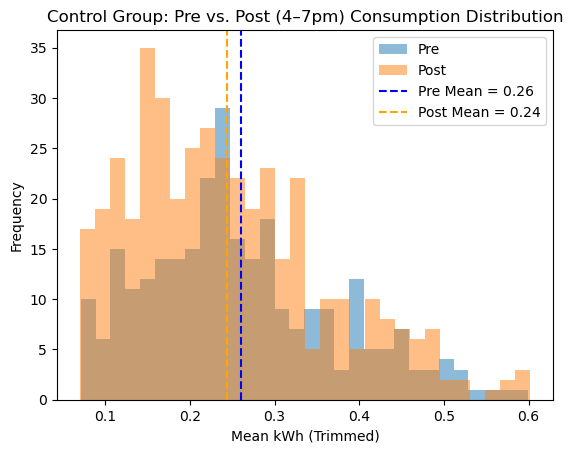

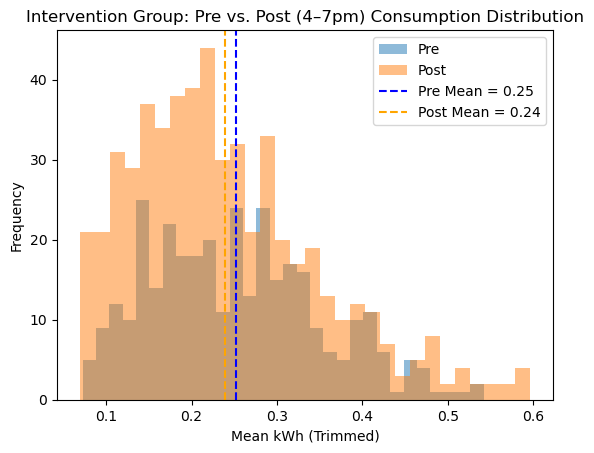

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pivot df_for_did_95 so that Pre/Post become columns
df_95_pivot = df_for_did_95.pivot(
    index=['ANON_ID','Group'],
    columns='Phase',
    values='consumption'
).reset_index()

# Separate out Control vs. Intervention
df_control_95 = df_95_pivot[df_95_pivot['Group'] == 'Control']
df_intervention_95 = df_95_pivot[df_95_pivot['Group'] == 'Intervention']

# Calculate means
control_pre_mean = df_control_95['Pre'].mean()
control_post_mean = df_control_95['Post'].mean()

intervention_pre_mean = df_intervention_95['Pre'].mean()
intervention_post_mean = df_intervention_95['Post'].mean()

# -------------------------------------------------------------------------
# 1) CONTROL GROUP: Overlaid Histograms + Mean Lines
# -------------------------------------------------------------------------
plt.figure()

# Histograms
plt.hist(df_control_95['Pre'].dropna(), bins=30, alpha=0.5, label='Pre')
plt.hist(df_control_95['Post'].dropna(), bins=30, alpha=0.5, label='Post')

# Vertical lines for means
plt.axvline(x=control_pre_mean, color='blue', linestyle='--',
            label=f"Pre Mean = {control_pre_mean:.2f}")
plt.axvline(x=control_post_mean, color='orange', linestyle='--',
            label=f"Post Mean = {control_post_mean:.2f}")

plt.title("Control Group: Pre vs. Post (4–7pm) Consumption Distribution")
plt.xlabel("Mean kWh (Trimmed)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# -------------------------------------------------------------------------
# 2) INTERVENTION GROUP: Overlaid Histograms + Mean Lines
# -------------------------------------------------------------------------
plt.figure()

# Histograms
plt.hist(df_intervention_95['Pre'].dropna(), bins=30, alpha=0.5, label='Pre')
plt.hist(df_intervention_95['Post'].dropna(), bins=30, alpha=0.5, label='Post')

# Vertical lines for means
plt.axvline(x=intervention_pre_mean, color='blue', linestyle='--',
            label=f"Pre Mean = {intervention_pre_mean:.2f}")
plt.axvline(x=intervention_post_mean, color='orange', linestyle='--',
            label=f"Post Mean = {intervention_post_mean:.2f}")

plt.title("Intervention Group: Pre vs. Post (4–7pm) Consumption Distribution")
plt.xlabel("Mean kWh (Trimmed)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


C:\Users\gerva\AppData\Local\Temp\ipykernel_10608\2033075914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control_95['Reduction_%'] = ((df_control_95['Pre'] - df_control_95['Post']) / df_control_95['Pre']) * 100
C:\Users\gerva\AppData\Local\Temp\ipykernel_10608\2033075914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intervention_95['Reduction_%'] = ((df_intervention_95['Pre'] - df_intervention_95['Post']) / df_intervention_95['Pre']) * 100


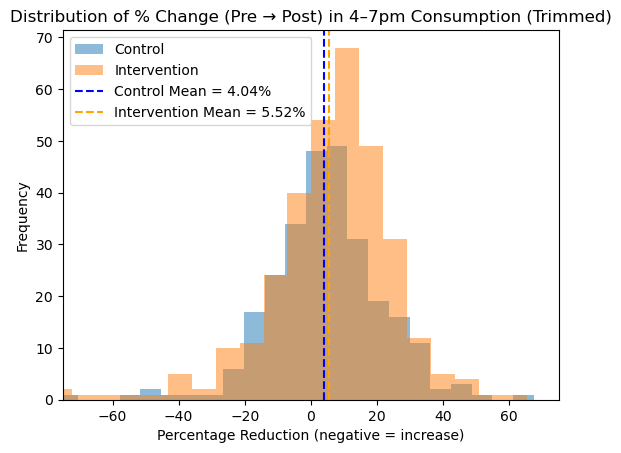

In [20]:
# Create a 'Reduction_%' column in each subset
df_control_95['Reduction_%'] = ((df_control_95['Pre'] - df_control_95['Post']) / df_control_95['Pre']) * 100
df_intervention_95['Reduction_%'] = ((df_intervention_95['Pre'] - df_intervention_95['Post']) / df_intervention_95['Pre']) * 100
control_mean_reduction = df_control_95['Reduction_%'].mean()
intervention_mean_reduction = df_intervention_95['Reduction_%'].mean()

plt.figure()

# Overlay two histograms on the same plot
plt.hist(df_control_95['Reduction_%'].dropna(), bins=30, alpha=0.5, label='Control')
plt.hist(df_intervention_95['Reduction_%'].dropna(), bins=30, alpha=0.5, label='Intervention')

# Means
plt.axvline(x=control_mean_reduction, color='blue', linestyle='--',
            label=f"Control Mean = {control_mean_reduction:.2f}%")
plt.axvline(x=intervention_mean_reduction, color='orange', linestyle='--',
            label=f"Intervention Mean = {intervention_mean_reduction:.2f}%")

plt.title("Distribution of % Change (Pre → Post) in 4–7pm Consumption (Trimmed)")
plt.xlabel("Percentage Reduction (negative = increase)")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(-75,75)

plt.show()


# PENDING: GLM w SocioEconomic Features

In [26]:
df_pivot

Phase,ANON_ID,Group,Post,Pre,Reduction_%,Free_Energy_Bracket
0,00423a851f653d52eaa28ef0d6efea73af2333e8ca4286...,Control,0.261594,NaN,NaN,Not Applicable
1,0045034694b28ba56978092fc4dd601c58774fd74c30b7...,Intervention,0.181874,0.178822,-1.706560,No Reward (< 5%)
2,006d592397024fcb6b2aa8a74193be5f08e71a528cf13d...,Intervention,0.346230,NaN,NaN,No Reward (< 5%)
3,01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...,Control,0.258379,0.221627,-16.583156,Not Applicable
4,01c05e36af0caaf19d6c35e0340d015ab07e742aa14fda...,Intervention,0.263910,0.245933,-7.309892,No Reward (< 5%)
...,...,...,...,...,...,...
1033,fe73ca8cdb323ce3042937f6f519c2a832bdb79b2e2737...,Control,0.210816,NaN,NaN,Not Applicable
1034,fef90b0143496f6e158ba9db416049340d590648659fc6...,Control,0.595371,0.498097,-19.529105,Not Applicable
1035,ffb113db46a42ae5b35d7544a6b168646ca92095ed2766...,Intervention,0.435086,NaN,NaN,No Reward (< 5%)
1036,ffba8412c38b3152abbf790a602f70ccea9313ab717d42...,Intervention,0.365056,0.342903,-6.460275,No Reward (< 5%)


In [34]:
import pandas as pd
import numpy as np

# Group df_combined_pre_post by [ANON_ID, Group, Phase], then compute mean ELEC_KWH.

df_agg = (
    df_combined_pre_post
    .groupby(['ANON_ID','Group','Phase'], as_index=False)
    .agg({'ELEC_KWH':'mean'})
)

# df_agg now has columns:
#   [ANON_ID, Group, Phase, ELEC_KWH]
# one row per ANON_ID-Group-Phase combination,
# with the average consumption for that combination.

# -------------------------------------------------------------------------
# 2) Pivot the grouped data on Phase => separate columns: 'Pre', 'Post'
# -------------------------------------------------------------------------
df_pivot = df_agg.pivot(
    index=['ANON_ID','Group'], 
    columns='Phase', 
    values='ELEC_KWH'
).reset_index()


# -------------------------------------------------------------------------
# 3) Merge with socio-economic data 

df_final = pd.merge(
    df_pivot, 
    socio_df,      
    on='ANON_ID',   
    how='left'      
)

# 4) Compute Delta or Delta_pct
# -------------------------------------------------------------------------
df_final.dropna(subset=['Pre','Post'], inplace=True)

df_final['Delta'] = df_final['Post'] - df_final['Pre']
df_final['Delta_pct'] = (df_final['Post'] - df_final['Pre']) / df_final['Pre']

# Now you can do separate analyses (e.g., regressions) for 
# Control vs. Intervention, or keep them together as you like.

df_control = df_final[df_final['Group'] == 'Control'].copy()
df_intervention = df_final[df_final['Group'] == 'Intervention'].copy()


In [39]:
df_control.head()


,ANON_ID,Group,Post,Pre,AGE_GROUP,INCOME_CATEGORY,HOUSEHOLD_OCCUPANCY,CHILDREN_AT_HOME,HOUSEHOLD_SIZE,NUMBER_OF_BEDROOMS,OCCUPATION,EMPLOYMENT_STATUS,HIGHEST_QUALIFICATION,HOME_OWNERSHIP,HOME_TYPE,HOME_VALUE,SOCIAL_GRADE,TARIFF_GROUP,Delta,Delta_pct
3,01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...,Control,0.258379,0.221627,55-64,"100,000+",Couple Household,0,2,4,Professional,Employed,University Degree or Higher,Owner Occupied,Detached House,500k+,Social grade B,EDF Essentials,0.036753,0.165832
6,029cf457eace7f2a0ed8f55912f926ba9855f3748a117f...,Control,0.194527,0.197656,65-74,"20,000-29,999",Couple Household,0,2,3,Retired,Not Employed,Secondary Education or Less,Owner Occupied,Semi-Detached House,250-500k,Social grade C2,Easy Online,-0.003128,-0.015828
8,034d4493bbb8bd1ae4b7496160610c6a2ab00100a79a7c...,Control,0.462929,0.501322,55-64,"100,000+",Couple Household,0,2,5+,Director/Managerial,Employed,University Degree or Higher,Owner Occupied,Terraced House,500k+,Social grade B,EDF Essentials,-0.038393,-0.076583
9,038dcb89b729d80f4b8308951234739418b5886fd79e28...,Control,0.272890,0.291909,65-74,"20,000-29,999",Couple Household,0,2,3,Retired,Not Employed,Secondary Education or Less,Owner Occupied,Terraced House,0-100k,Social grade C2,EDF Essentials,-0.019020,-0.065156
16,054b88a4807b59fb512c26c563b70b99c62c8624b6628d...,Control,0.075311,0.081028,65-74,"10,000-19,999",Single Adult Household,0,1,2,Retired,Not Employed,A Level Equivalent,Owner Occupied,Flat or Maisonette,0-100k,Social grade C2,EDF Essentials,-0.005718,-0.070563


### Linear regression

In [38]:
# Second part of the GLM
formula_delta = """
Delta ~ C(AGE_GROUP)
      + C(INCOME_CATEGORY)
      + C(HOUSEHOLD_OCCUPANCY)
      + C(CHILDREN_AT_HOME)
      + C(HOUSEHOLD_SIZE)
      + C(NUMBER_OF_BEDROOMS)
      + C(OCCUPATION)
      + C(EMPLOYMENT_STATUS)
      + C(HIGHEST_QUALIFICATION)
      + C(HOME_OWNERSHIP)
      + C(HOME_TYPE)
      + C(HOME_VALUE)
      + C(SOCIAL_GRADE)
      + C(TARIFF_GROUP)
"""

formula_pct = """
Delta_pct ~ C(AGE_GROUP)
          + C(INCOME_CATEGORY)
          + C(HOUSEHOLD_OCCUPANCY)
          + C(CHILDREN_AT_HOME)
          + C(HOUSEHOLD_SIZE)
          + C(NUMBER_OF_BEDROOMS)
          + C(OCCUPATION)
          + C(EMPLOYMENT_STATUS)
          + C(HIGHEST_QUALIFICATION)
          + C(HOME_OWNERSHIP)
          + C(HOME_TYPE)
          + C(HOME_VALUE)
          + C(SOCIAL_GRADE)
          + C(TARIFF_GROUP)
"""

# ------------------------------------------------------------------------------
# 6) Fit regressions: One for Control, one for Intervention, on Delta
# ------------------------------------------------------------------------------
print("=== Control: Delta (Post - Pre) Regression ===")
model_control_delta = smf.ols(formula_delta, data=df_control).fit()
print(model_control_delta.summary())

print("\n=== Intervention: Delta (Post - Pre) Regression ===")
model_intervention_delta = smf.ols(formula_delta, data=df_intervention).fit()
print(model_intervention_delta.summary())

# ------------------------------------------------------------------------------
# 7) Fit regressions: One for Control, one for Intervention, on Delta_pct
# ------------------------------------------------------------------------------
print("\n=== Control: Delta_pct ((Post - Pre)/Pre) Regression ===")
model_control_pct = smf.ols(formula_pct, data=df_control).fit()
print(model_control_pct.summary())

print("\n=== Intervention: Delta_pct ((Post - Pre)/Pre) Regression ===")
model_intervention_pct = smf.ols(formula_pct, data=df_intervention).fit()
print(model_intervention_pct.summary())

=== Control: Delta (Post - Pre) Regression ===
                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                 -0.072
Method:                 Least Squares   F-statistic:                    0.6657
Date:                Mon, 24 Mar 2025   Prob (F-statistic):              0.965
Time:                        12:12:46   Log-Likelihood:                 465.68
No. Observations:                 286   AIC:                            -815.4
Df Residuals:                     228   BIC:                            -603.3
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

# Tree based GLM


## All socioeconomic features

### Control

In [42]:
import pandas as pd
import numpy as np

# For splitting data
from sklearn.model_selection import train_test_split

# For pipeline and column transformations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# The tree-based model (GBM)
from sklearn.ensemble import GradientBoostingRegressor

# -------------------------------------------------------------------------
# 1) Suppose you already have a DataFrame "df" with columns:
#    [AGE_GROUP, INCOME_CATEGORY, ..., Delta] or Delta_pct as the target.
#    Or if you have 'Pre','Post', you can add a column df['Delta'] = df['Post'] - df['Pre'].
# -------------------------------------------------------------------------
# For this example, let's say the target is 'Delta'.
# We'll treat some columns as numeric, others as categorical.

df = df_control

# Identify which columns are categorical vs numeric
categorical_cols = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
    'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
    'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
    'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE',
    'SOCIAL_GRADE', 'TARIFF_GROUP'
]
# Suppose you have some numeric columns (none in this example, but in your real data you might).
numeric_cols = []  # e.g. ['some_numeric_column', 'another_numeric']

# We'll use 'Delta' as the target.
target_col = 'Delta'

# Drop any rows missing relevant columns
df = df.dropna(subset=categorical_cols + [target_col]).copy()

# Define X and y
X = df[categorical_cols + numeric_cols]
y = df[target_col]

# -------------------------------------------------------------------------
# 2) Split into train/test (or train/validation)
# -------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# -------------------------------------------------------------------------
# 3) Build a pipeline that one-hot encodes the categorical columns
#    and applies a GradientBoostingRegressor.
# -------------------------------------------------------------------------
# ColumnTransformer to handle different data types:
# - OneHotEncoder for categorical
# - (Optional) StandardScaler for numeric if you want
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
numeric_transformer = StandardScaler()

# We'll build a transformer specifying how to process each subset of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ]
)

# Then we pipe that into a tree-based regressor
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('gbm', GradientBoostingRegressor(
        loss='squared_error',   # or 'absolute_error', 'poisson', etc.
        n_estimators=200,       # number of trees
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# -------------------------------------------------------------------------
# 4) Fit the pipeline on the training set
# -------------------------------------------------------------------------
model.fit(X_train, y_train)

# -------------------------------------------------------------------------
# 5) Evaluate on the test set
# -------------------------------------------------------------------------
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R^2: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")

# -------------------------------------------------------------------------
# 6) (Optional) Inspect Feature Importances
# -------------------------------------------------------------------------
# Once fitted, we can retrieve the internal GBM feature importances.
# But note that with one-hot encoding, you'll see many dummy columns 
# instead of the raw feature names. 
# If you'd like a more interpretable approach, consider partial dependence plots.

# We can only retrieve importances from the final estimator:
gbm_model = model.named_steps['gbm']
importances = gbm_model.feature_importances_
print("Raw importances shape:", importances.shape)

# A quick approach to match them back to actual dummy-coded names:
ohe = model.named_steps['preprocess'].transformers_[0][1]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

feature_names = list(ohe_feature_names)
# if numeric_cols exist, they come after, e.g. feature_names += numeric_cols

# Print out top 10 features by importance (if you want):
feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for fname, imp in feat_imp[:10]:
    print(f"{fname}: {imp:.3f}")


Test R^2: -0.205
Test RMSE: 0.071
Raw importances shape: (58,)
HOME_OWNERSHIP_Private Renting: 0.096
HOME_VALUE_150-250k: 0.062
NUMBER_OF_BEDROOMS_4: 0.060
AGE_GROUP_55-64: 0.059
AGE_GROUP_25-34: 0.056
TARIFF_GROUP_Easy Online: 0.054
SOCIAL_GRADE_Social grade B: 0.049
INCOME_CATEGORY_100,000+: 0.043
INCOME_CATEGORY_75,000-99,999: 0.032
EMPLOYMENT_STATUS_Not Employed: 0.031


### Intervention

In [47]:

df = df_intervention

# Identify which columns are categorical vs numeric
categorical_cols = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
    'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
    'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
    'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE',
    'SOCIAL_GRADE', 'TARIFF_GROUP'
]

# Suppose you have some numeric columns (none in this example, but in your real data you might).
numeric_cols = []  # e.g. ['some_numeric_column', 'another_numeric']

# We'll use 'Delta' as the target.
target_col = 'Delta'

# Drop any rows missing relevant columns
df = df.dropna(subset=categorical_cols + [target_col]).copy()

# Define X and y
X = df[categorical_cols + numeric_cols]
y = df[target_col]

# -------------------------------------------------------------------------
# 2) Split into train/test (or train/validation)
# -------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 3) Build a pipeline that one-hot encodes the categorical columns
#    and applies a GradientBoostingRegressor.

categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
numeric_transformer = StandardScaler()

# We'll build a transformer specifying how to process each subset of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ]
)

# Then we pipe that into a tree-based regressor
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('gbm', GradientBoostingRegressor(
        loss='squared_error',   # or 'absolute_error', 'poisson', etc.
        n_estimators=200,       # number of trees
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# -------------------------------------------------------------------------
# 4) Fit the pipeline on the training set
# -------------------------------------------------------------------------
model.fit(X_train, y_train)

# -------------------------------------------------------------------------
# 5) Evaluate on the test set
# -------------------------------------------------------------------------
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R^2: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")

# -------------------------------------------------------------------------
# 6) (Optional) Inspect Feature Importances
# -------------------------------------------------------------------------
# Once fitted, we can retrieve the internal GBM feature importances.
# But note that with one-hot encoding, you'll see many dummy columns 
# instead of the raw feature names. 
# If you'd like a more interpretable approach, consider partial dependence plots.

# We can only retrieve importances from the final estimator:
gbm_model = model.named_steps['gbm']
importances = gbm_model.feature_importances_
print("Raw importances shape:", importances.shape)

# A quick approach to match them back to actual dummy-coded names:
ohe = model.named_steps['preprocess'].transformers_[0][1]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

feature_names = list(ohe_feature_names)
# if numeric_cols exist, they come after, e.g. feature_names += numeric_cols

# Print out top 10 features by importance (if you want):
feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for fname, imp in feat_imp[:10]:
    print(f"{fname}: {imp:.3f}")


Test R^2: -1.241
Test RMSE: 0.081
Raw importances shape: (57,)
OCCUPATION_Student: 0.137
TARIFF_GROUP_Standard: 0.104
NUMBER_OF_BEDROOMS_4: 0.079
INCOME_CATEGORY_75,000-99,999: 0.068
HOUSEHOLD_SIZE_3-4: 0.052
TARIFF_GROUP_EDF Essentials: 0.047
HOUSEHOLD_OCCUPANCY_Single Adult Household: 0.041
CHILDREN_AT_HOME_2+: 0.037
SOCIAL_GRADE_Social grade C1: 0.033
OCCUPATION_Professional: 0.025


C:\Users\gerva\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Some socioeconomic variables

In [46]:
import pandas as pd
import numpy as np

# For splitting data
from sklearn.model_selection import train_test_split

# For pipeline and column transformations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# The tree-based model (GBM)
from sklearn.ensemble import GradientBoostingRegressor

# -------------------------------------------------------------------------
# 1) Suppose you already have a DataFrame "df" with columns:
#    [AGE_GROUP, INCOME_CATEGORY, ..., Delta] or Delta_pct as the target.
#    Or if you have 'Pre','Post', you can add a column df['Delta'] = df['Post'] - df['Pre'].
# -------------------------------------------------------------------------
# For this example, let's say the target is 'Delta'.
# We'll treat some columns as numeric, others as categorical.

df = df_intervention

# Identify which columns are categorical vs numeric
categorical_cols = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY'
]
'''
    ,
    'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
    'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
    'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE',
    'SOCIAL_GRADE', 'TARIFF_GROUP'
]
'''
# Suppose you have some numeric columns (none in this example, but in your real data you might).
numeric_cols = []  # e.g. ['some_numeric_column', 'another_numeric']

# We'll use 'Delta' as the target.
target_col = 'Delta'

# Drop any rows missing relevant columns
df = df.dropna(subset=categorical_cols + [target_col]).copy()

# Define X and y
X = df[categorical_cols + numeric_cols]
y = df[target_col]

# -------------------------------------------------------------------------
# 2) Split into train/test (or train/validation)
# -------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# -------------------------------------------------------------------------
# 3) Build a pipeline that one-hot encodes the categorical columns
#    and applies a GradientBoostingRegressor.
# -------------------------------------------------------------------------
# ColumnTransformer to handle different data types:
# - OneHotEncoder for categorical
# - (Optional) StandardScaler for numeric if you want
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
numeric_transformer = StandardScaler()

# We'll build a transformer specifying how to process each subset of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ]
)

# Then we pipe that into a tree-based regressor
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('gbm', GradientBoostingRegressor(
        loss='squared_error',   # or 'absolute_error', 'poisson', etc.
        n_estimators=200,       # number of trees
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# -------------------------------------------------------------------------
# 4) Fit the pipeline on the training set
# -------------------------------------------------------------------------
model.fit(X_train, y_train)

# -------------------------------------------------------------------------
# 5) Evaluate on the test set
# -------------------------------------------------------------------------
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R^2: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")

# -------------------------------------------------------------------------
# 6) (Optional) Inspect Feature Importances
# -------------------------------------------------------------------------
# Once fitted, we can retrieve the internal GBM feature importances.
# But note that with one-hot encoding, you'll see many dummy columns 
# instead of the raw feature names. 
# If you'd like a more interpretable approach, consider partial dependence plots.

# We can only retrieve importances from the final estimator:
gbm_model = model.named_steps['gbm']
importances = gbm_model.feature_importances_
print("Raw importances shape:", importances.shape)

# A quick approach to match them back to actual dummy-coded names:
ohe = model.named_steps['preprocess'].transformers_[0][1]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

feature_names = list(ohe_feature_names)
# if numeric_cols exist, they come after, e.g. feature_names += numeric_cols

# Print out top 10 features by importance (if you want):
feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for fname, imp in feat_imp[:10]:
    print(f"{fname}: {imp:.3f}")


Test R^2: -0.170
Test RMSE: 0.059
Raw importances shape: (15,)
HOUSEHOLD_OCCUPANCY_Single Adult Household: 0.403
AGE_GROUP_65-74: 0.171
INCOME_CATEGORY_10,000-19,999: 0.064
INCOME_CATEGORY_30,000-39,999: 0.059
AGE_GROUP_25-34: 0.056
INCOME_CATEGORY_40,000-49,999: 0.048
INCOME_CATEGORY_100,000+: 0.039
INCOME_CATEGORY_50,000-74,999: 0.032
AGE_GROUP_35-44: 0.030
INCOME_CATEGORY_75,000-99,999: 0.028


# Based on poor results, we think its appropiate to do feature engineering

# Feature Engineering Summary

| Original Column          | Feature Engineering Approach                                               | New Column / Encoding             |
|--------------------------|----------------------------------------------------------------------------|-----------------------------------|
| `AGE_GROUP`              | Replaced each age bracket with its midpoint (e.g. '18-24' → 21, '75+' → 80)| `AGE_GROUP_num`                   |
| `INCOME_CATEGORY`        | Mapped each income bracket to a midpoint (e.g. '10,000-19,999' → 15,000)    | `INCOME_CATEGORY_num`             |
| `HOUSEHOLD_OCCUPANCY`    | Converted occupancy type to integer codes (Single →1, Couple →2, Multi →3) | `HOUSEHOLD_OCCUPANCY_num`         |
| `CHILDREN_AT_HOME`       | '0' → 0, '1' → 1, '2+' → 2                                                 | `CHILDREN_AT_HOME_num`            |
| `HOUSEHOLD_SIZE`         | '1' → 1, '2' → 2, '3-4' → 3.5, '5+' → 5                                     | `HOUSEHOLD_SIZE_num`              |
| `NUMBER_OF_BEDROOMS`     | '1' → 1, '2' → 2, '3' → 3, '4' → 4, '5+' → 5                                | `NUMBER_OF_BEDROOMS_num`          |
| `HIGHEST_QUALIFICATION`  | Ordinal encoding (e.g. 0 = Secondary or Less, 3 = University Degree)        | `HIGHEST_QUALIFICATION_num`       |
| `HOME_VALUE`             | Mapped each bracket to a midpoint (e.g. '100-150k' → 125,000)              | `HOME_VALUE_num`                  |
| `SOCIAL_GRADE`           | Assigned numeric ranks (A →1, B →2, C1 →3, C2 →4, D →5)                     | `SOCIAL_GRADE_num`                |
| `TARIFF_GROUP`           | **Left as categorical** (unchanged / no numeric encoding)                  | N/A                               |



In [50]:
import pandas as pd
import os

print(f"Socio-economic data shape before cleaning: {socio_df.shape}")

# -------------------------------------------------------------------------
# 1) Example: Numeric Mapping Dictionaries
# -------------------------------------------------------------------------
# Age group midpoints
age_map = {
    '18-24': 21,
    '25-34': 29.5,
    '35-44': 39.5,
    '45-54': 49.5,
    '55-64': 59.5,
    '65-74': 69.5,
    '75+': 80   # arbitrary guess for 75+
}

# Income brackets (midpoints in thousands, e.g. "10,000-19,999" -> 15k).
income_map = {
    '0-9,999': 5_000,
    '10,000-19,999': 15_000,
    '20,000-29,999': 25_000,
    '30,000-39,999': 35_000,
    '40,000-49,999': 45_000,
    '50,000-74,999': 62_500,
    '75,000-99,999': 87_500,
    '100,000+': 150_000   # or 150_000, your choice for open-ended
}

# Household occupancy: Single=1, Couple=2, Multi=3
household_occupancy_map = {
    'Single Adult Household': 1,
    'Couple Household': 2,
    'Multi-Occupancy Household': 3
}

# Children: '2+' -> 2 or 3. We'll pick 2 to keep it simple
children_map = {
    '0': 0,
    '1': 1,
    '2+': 2
}

# Household size: '3-4' -> 3.5 or 4. We'll pick 3.5
household_size_map = {
    '1': 1,
    '2': 2,
    '3-4': 3.5,
    '5+': 5
}

# Number of bedrooms: '5+' -> 5
bedrooms_map = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5+': 5
}

# Highest qualification (ordinal ranks):
# e.g. 0='Secondary or less', 1='GCSE', 2='A Level', 3='Uni Degree'
qualification_map = {
    'Secondary Education or Less': 0,
    'GCSE Equivalent': 1,
    'A Level Equivalent': 2,
    'University Degree or Higher': 3
}

# Home value midpoints (in, say, thousands or raw integers?). We'll pick integers:
home_value_map = {
    '0-100k': 50_000,
    '100-150k': 125_000,
    '150-250k': 200_000,
    '250-500k': 375_000,
    '500k+': 500_000
}

# Social grade (rough ordinal from A to D)
# E.g. A=1, B=2, C1=3, C2=4, D=5
social_grade_map = {
    'Social grade A': 1,
    'Social grade B': 2,
    'Social grade C1': 3,
    'Social grade C2': 4,
    'Social grade D': 5
}
'''
# Occupation, Employment, Home Ownership, Home Type, Tariff Group
# are typically nominal, no numeric range. You can assign arbitrary integers:
# (This is optional if you prefer one-hot encoding or if there's no natural order.)
occupation_map = {
    # Example arbitrary codes for demonstration
    'Director/Managerial': 1,
    'Looking after home': 2,
    'Office Worker': 3,
    'Professional': 4,
    'Retired': 5,
    'Service Sector': 6,
    'Skilled Manual Worker': 7,
    'Student': 8,
    'Unemployed': 9
}
employment_map = {
    'Employed': 1,
    'Not Employed': 0
}
home_ownership_map = {
    'Owner Occupied': 1,
    'Private Renting': 2,
    'Social Renting': 3
}
home_type_map = {
    'Detached House': 1,
    'Flat or Maisonette': 2,
    'Semi-Detached House': 3,
    'Terraced House': 4
}
tariff_map = {
    'Deemed': 1,
    'EDF Essentials': 2,
    'Easy Online': 3,
    'Engage': 4,
    'Essentials Exclusive': 5,
    'Fix Total Service': 6,
    'Goelectric': 7,
    'Goelectric Exclusive': 8,
    'Safeguard Assist': 9,
    'Simply Online': 10,
    'Standard': 11,
    'Total Service': 12
}
'''
# 2) Apply the mappings to create numeric columns

socio_df_mapped = socio_df
socio_df_mapped['AGE_GROUP_num'] = socio_df_mapped['AGE_GROUP'].map(age_map)
socio_df_mapped['INCOME_CATEGORY_num'] = socio_df_mapped['INCOME_CATEGORY'].map(income_map)
socio_df_mapped['HOUSEHOLD_OCCUPANCY_num'] = socio_df_mapped['HOUSEHOLD_OCCUPANCY'].map(household_occupancy_map)
socio_df_mapped['CHILDREN_AT_HOME_num'] = socio_df_mapped['CHILDREN_AT_HOME'].map(children_map)
socio_df_mapped['HOUSEHOLD_SIZE_num'] = socio_df_mapped['HOUSEHOLD_SIZE'].map(household_size_map)
socio_df_mapped['NUMBER_OF_BEDROOMS_num'] = socio_df_mapped['NUMBER_OF_BEDROOMS'].map(bedrooms_map)
socio_df_mapped['HIGHEST_QUALIFICATION_num'] = socio_df_mapped['HIGHEST_QUALIFICATION'].map(qualification_map)
socio_df_mapped['HOME_VALUE_num'] = socio_df_mapped['HOME_VALUE'].map(home_value_map)
socio_df_mapped['SOCIAL_GRADE_num'] = socio_df_mapped['SOCIAL_GRADE'].map(social_grade_map)
'''
socio_df['OCCUPATION_num'] = socio_df['OCCUPATION'].map(occupation_map)
socio_df['EMPLOYMENT_STATUS_num'] = socio_df['EMPLOYMENT_STATUS'].map(employment_map)
socio_df['HOME_OWNERSHIP_num'] = socio_df['HOME_OWNERSHIP'].map(home_ownership_map)
socio_df['HOME_TYPE_num'] = socio_df['HOME_TYPE'].map(home_type_map)
socio_df['TARIFF_GROUP_num'] = socio_df['TARIFF_GROUP'].map(tariff_map)
'''

# 3) (Optional) Inspect your new numeric columns
# -------------------------------------------------------------------------
print(socio_df_mapped[['AGE_GROUP','AGE_GROUP_num','INCOME_CATEGORY','INCOME_CATEGORY_num']].head(10))


Socio-economic data shape before cleaning: (1044, 15)
  AGE_GROUP AGE_GROUP_num INCOME_CATEGORY INCOME_CATEGORY_num
0     35-44          39.5   50,000-74,999               62500
1     65-74          69.5   30,000-39,999               35000
2     55-64          59.5         0-9,999                5000
3       75+          80.0   20,000-29,999               25000
4     55-64          59.5        100,000+              150000
5       75+          80.0   30,000-39,999               35000
6     65-74          69.5   20,000-29,999               25000
7     65-74          69.5   40,000-49,999               45000
8     65-74          69.5   20,000-29,999               25000
9     18-24          21.0   75,000-99,999               87500


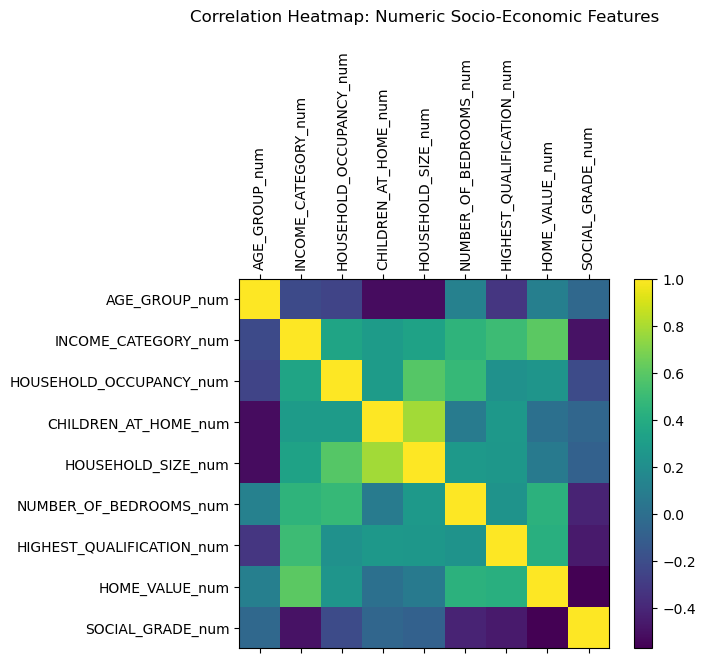

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Identify the numeric columns you want to include
numeric_cols = [
    'AGE_GROUP_num',
    'INCOME_CATEGORY_num',
    'HOUSEHOLD_OCCUPANCY_num',
    'CHILDREN_AT_HOME_num',
    'HOUSEHOLD_SIZE_num',
    'NUMBER_OF_BEDROOMS_num',
    'HIGHEST_QUALIFICATION_num',
    'HOME_VALUE_num',
    'SOCIAL_GRADE_num'
    # Add more if you have them, e.g. 'OCCUPATION_num', etc.
]

# 2) Filter to those columns in your mapped DataFrame
df_numeric = socio_df_mapped[numeric_cols].copy()

# 3) Compute the correlation matrix
corr_matrix = df_numeric.corr()

# 4) Plot the heatmap using matplotlib
plt.figure()
plt.matshow(corr_matrix, fignum=0)  # 'fignum=0' re-uses the same figure or you can omit it
plt.title("Correlation Heatmap: Numeric Socio-Economic Features", pad=20)

# 5) Customize axes ticks
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)

# 6) Add a colorbar to show correlation scale
plt.colorbar()

plt.show()


#### Now that we have "better" features, lets try GLM

In [68]:
import pandas as pd


old_categorical_cols = [
    'AGE_GROUP',
    'INCOME_CATEGORY',
    'HOUSEHOLD_OCCUPANCY',
    'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE',
    'NUMBER_OF_BEDROOMS',
    'OCCUPATION',
    'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION',
    'HOME_OWNERSHIP',
    'HOME_TYPE',
    'HOME_VALUE',
    'SOCIAL_GRADE',
    # 'TARIFF_GROUP'
]

new_numeric_cols = [
    'AGE_GROUP_num',
    'INCOME_CATEGORY_num',
    'HOUSEHOLD_OCCUPANCY_num',
    'CHILDREN_AT_HOME_num',
    'HOUSEHOLD_SIZE_num',
    'NUMBER_OF_BEDROOMS_num',
    'HIGHEST_QUALIFICATION_num',
    'HOME_VALUE_num',
    'SOCIAL_GRADE_num',
    # 
]


df_control_merged = pd.merge(
    df_control, 
    socio_df_mapped[['ANON_ID'] + new_numeric_cols],  # keep only the ID + numeric cols
    on='ANON_ID', 
    how='inner'
)

# Drop the old categorical columns that have now been replaced
df_control_merged.drop(columns=old_categorical_cols, inplace=True, errors='ignore')

print("[INFO] Control merged shape:", df_control_merged.shape)
print(df_control_merged.columns)

df_intervention_merged = pd.merge(
    df_intervention,
    socio_df_mapped[['ANON_ID'] + new_numeric_cols],
    on='ANON_ID',
    how='inner'
)

df_intervention_merged.drop(columns=old_categorical_cols, inplace=True, errors='ignore')

print("[INFO] Intervention merged shape:", df_intervention_merged.shape)
print(df_intervention_merged.columns)



[INFO] Control merged shape: (286, 16)
Index(['ANON_ID', 'Group', 'Post', 'Pre', 'TARIFF_GROUP', 'Delta', 'Delta_pct',
       'AGE_GROUP_num', 'INCOME_CATEGORY_num', 'HOUSEHOLD_OCCUPANCY_num',
       'CHILDREN_AT_HOME_num', 'HOUSEHOLD_SIZE_num', 'NUMBER_OF_BEDROOMS_num',
       'HIGHEST_QUALIFICATION_num', 'HOME_VALUE_num', 'SOCIAL_GRADE_num'],
      dtype='object')
[INFO] Intervention merged shape: (342, 16)
Index(['ANON_ID', 'Group', 'Post', 'Pre', 'TARIFF_GROUP', 'Delta', 'Delta_pct',
       'AGE_GROUP_num', 'INCOME_CATEGORY_num', 'HOUSEHOLD_OCCUPANCY_num',
       'CHILDREN_AT_HOME_num', 'HOUSEHOLD_SIZE_num', 'NUMBER_OF_BEDROOMS_num',
       'HIGHEST_QUALIFICATION_num', 'HOME_VALUE_num', 'SOCIAL_GRADE_num'],
      dtype='object')


In [69]:
print(df_control_merged.shape)
print(df_control.shape)

(286, 16)
(286, 20)


In [70]:
print(df_intervention_merged.shape)
print(df_intervention.shape)

(342, 16)
(342, 20)


In [65]:
df_intervention_merged.head()


,ANON_ID,Group,Post,Pre,Delta,Delta_pct,AGE_GROUP_num,INCOME_CATEGORY_num,HOUSEHOLD_OCCUPANCY_num,CHILDREN_AT_HOME_num,HOUSEHOLD_SIZE_num,NUMBER_OF_BEDROOMS_num,HIGHEST_QUALIFICATION_num,HOME_VALUE_num,SOCIAL_GRADE_num
0,0045034694b28ba56978092fc4dd601c58774fd74c30b7...,Intervention,0.181874,0.178822,0.003052,0.017066,69.5,45000,2,0,2.0,4,2,200000,4
1,01c05e36af0caaf19d6c35e0340d015ab07e742aa14fda...,Intervention,0.263910,0.245933,0.017977,0.073099,59.5,62500,1,0,1.0,1,3,200000,3
2,03edaa0ab8ac6da0cf0a3c4f9e7bd6e65ba4bd4dec3ee3...,Intervention,0.077191,0.102109,-0.024918,-0.244030,59.5,25000,2,0,2.0,3,1,125000,5
3,04ef482b455c0a46fd1d52a1a4cc8a11cb89424035d2f2...,Intervention,0.306281,0.309915,-0.003634,-0.011726,59.5,87500,2,1,2.0,4,3,375000,2
4,04fef70b0ec49afb0cbcddbaaef57a679c2d4dcd754c5f...,Intervention,0.349290,0.373171,-0.023881,-0.063994,59.5,25000,2,0,2.0,3,1,375000,3


In [74]:


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Example usage:
df = df_intervention_merged.copy()

categorical_cols = ['TARIFF_GROUP']
numeric_cols = [
    'AGE_GROUP_num',
    'INCOME_CATEGORY_num',
    'HOUSEHOLD_OCCUPANCY_num',
    'CHILDREN_AT_HOME_num',
    'HOUSEHOLD_SIZE_num',
    'NUMBER_OF_BEDROOMS_num',
    'HIGHEST_QUALIFICATION_num',
    'HOME_VALUE_num',
    'SOCIAL_GRADE_num'
]

target_col = 'Delta'

# Drop rows missing relevant columns
df = df.dropna(subset=categorical_cols + [target_col])

X = df[categorical_cols + numeric_cols]
y = df[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Define transformations
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('gbm', GradientBoostingRegressor(
        loss='squared_error',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R^2: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")

# Feature importances
gbm_model = model.named_steps['gbm']
importances = gbm_model.feature_importances_

ohe = model.named_steps['preprocess'].transformers_[0][1]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

feature_names = list(ohe_feature_names)
feature_names += numeric_cols  # append numeric columns

feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for fname, imp in feat_imp[:10]:
    print(f"{fname}: {imp:.3f}")


Test R^2: -0.507
Test RMSE: 0.066
AGE_GROUP_num: 0.273
HOUSEHOLD_SIZE_num: 0.194
INCOME_CATEGORY_num: 0.094
TARIFF_GROUP_EDF Essentials: 0.086
NUMBER_OF_BEDROOMS_num: 0.061
HOME_VALUE_num: 0.057
CHILDREN_AT_HOME_num: 0.054
HIGHEST_QUALIFICATION_num: 0.044
TARIFF_GROUP_Standard: 0.041
SOCIAL_GRADE_num: 0.034


C:\Users\gerva\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [73]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Example usage:
df = df_control_merged.copy()

categorical_cols = ['TARIFF_GROUP']
numeric_cols = [
    'AGE_GROUP_num',
    'INCOME_CATEGORY_num',
    'HOUSEHOLD_OCCUPANCY_num',
    'CHILDREN_AT_HOME_num',
    'HOUSEHOLD_SIZE_num',
    'NUMBER_OF_BEDROOMS_num',
    'HIGHEST_QUALIFICATION_num',
    'HOME_VALUE_num',
    'SOCIAL_GRADE_num'
]

target_col = 'Delta'

# Drop rows missing relevant columns
df = df.dropna(subset=categorical_cols + [target_col])

X = df[categorical_cols + numeric_cols]
y = df[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Define transformations
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('gbm', GradientBoostingRegressor(
        loss='squared_error',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R^2: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")

# Feature importances
gbm_model = model.named_steps['gbm']
importances = gbm_model.feature_importances_

ohe = model.named_steps['preprocess'].transformers_[0][1]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

feature_names = list(ohe_feature_names)
feature_names += numeric_cols  # append numeric columns

feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for fname, imp in feat_imp[:10]:
    print(f"{fname}: {imp:.3f}")


Test R^2: -0.148
Test RMSE: 0.069
INCOME_CATEGORY_num: 0.168
AGE_GROUP_num: 0.132
NUMBER_OF_BEDROOMS_num: 0.123
SOCIAL_GRADE_num: 0.119
HOME_VALUE_num: 0.096
CHILDREN_AT_HOME_num: 0.090
TARIFF_GROUP_Easy Online: 0.075
HOUSEHOLD_SIZE_num: 0.068
HIGHEST_QUALIFICATION_num: 0.048
TARIFF_GROUP_Standard: 0.032


# Function to generate plots

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.stats import ttest_rel, wilcoxon  # for paired Mann-Whitney is "wilcoxon" in SciPy

def generate_intervention_analysis(
        include_time_of_day_start=0,
        include_time_of_day_end=24,
        exclude_time_of_day_start=None,
        exclude_time_of_day_end=None,
        pre_start=pd.Timestamp("2023-02-01 00:00:00"),
        pre_end=pd.Timestamp("2024-01-31 23:59:59"),
        post_start=pd.Timestamp("2024-04-01 00:00:00"),
        post_end=pd.Timestamp("2024-12-31 23:59:59"),
        lower_end_consumption=2.5,
        higher_end_consumption=97.5,
        file_path=r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"
    ):
    """
    Studies whether the Intervention group's Post usage < Pre usage, using:
      - Paired T-test
      - Paired Mann-Whitney (Wilcoxon signed-rank)
    Also plots distributions for reference. We optionally exclude a subrange
    from the daily hours (e.g., exclude 16–19 but keep the rest).

    Steps:
      1) Read & label CSVs for (Control & Intervention) x (Pre & Post).
      2) Filter hours in [include_time_of_day_start, include_time_of_day_end),
         then exclude [exclude_time_of_day_start, exclude_time_of_day_end) if provided.
      3) Pivot so each row has (Pre, Post), then compute %Change.
      4) Trims outliers in Pre & Post.
      5) Plots:
         - Control: Pre vs. Post
         - Intervention: Pre vs. Post
         - Distribution of %Change
      6) For the Intervention group, do:
         (A) Paired T-test: H0 => mean(Post)=mean(Pre), H1 => Post<Pre
         (B) Paired Mann-Whitney (Wilcoxon) test: same hypothesis.

    Returns
    -------
    None
        Displays plots and prints test results.
    """

    from scipy.stats import ttest_rel, wilcoxon

    def preprocess_and_aggregate(file_name, start_date, end_date):
        df = pd.read_csv(os.path.join(file_path, file_name))
        df = df.rename(columns={'Unnamed: 0': 'Time'})
        df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S")

        # Filter by date
        df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]

        # Keep hours in [include_time_of_day_start, include_time_of_day_end)
        df = df[
            (df['Time'].dt.hour >= include_time_of_day_start) &
            (df['Time'].dt.hour < include_time_of_day_end)
        ]

        # Exclude subrange if specified
        if exclude_time_of_day_start is not None and exclude_time_of_day_end is not None:
            df = df[~(
                (df['Time'].dt.hour >= exclude_time_of_day_start) &
                (df['Time'].dt.hour < exclude_time_of_day_end)
            )]

        # Melt and average
        df_long = df.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')
        df_long.drop_duplicates(subset=['Time','ANON_ID'], inplace=True)
        df_agg = df_long.groupby('ANON_ID', as_index=False)['ELEC_KWH'].mean()
        return df_agg

    # 1) Read data
    df_control_pre  = preprocess_and_aggregate("controlePreConsolide.csv", pre_start, pre_end)
    df_control_post = preprocess_and_aggregate("controleConsolide.csv",    post_start, post_end)

    df_intervention_pre  = preprocess_and_aggregate("interventionPreConsolide.csv", pre_start, pre_end)
    df_intervention_post = preprocess_and_aggregate("interventionConsolide.csv",    post_start, post_end)

    df_control_pre['Group'] = 'Control';      df_control_pre['Phase'] = 'Pre'
    df_control_post['Group']= 'Control';      df_control_post['Phase']= 'Post'
    df_intervention_pre['Group']   = 'Intervention'; df_intervention_pre['Phase']   = 'Pre'
    df_intervention_post['Group']  = 'Intervention'; df_intervention_post['Phase']  = 'Post'

    df_combined = pd.concat([
        df_control_pre, df_control_post,
        df_intervention_pre, df_intervention_post
    ], ignore_index=True)

    # 2) pivot => Pre / Post
    df_mean = (df_combined
               .groupby(['ANON_ID','Group','Phase'], as_index=False)
               .agg({'ELEC_KWH':'mean'}))

    df_pivot = df_mean.pivot(index=['ANON_ID','Group'], columns='Phase', values='ELEC_KWH').reset_index()
    df_pivot.dropna(subset=['Pre','Post'], inplace=True)

    # 3) compute %Change
    df_pivot['Reduction_%'] = ((df_pivot['Pre'] - df_pivot['Post']) / df_pivot['Pre']) * 100

    # 4) outlier trimming
    pre_lower = np.percentile(df_pivot['Pre'],  lower_end_consumption)
    pre_upper = np.percentile(df_pivot['Pre'],  higher_end_consumption)
    post_lower = np.percentile(df_pivot['Post'], lower_end_consumption)
    post_upper = np.percentile(df_pivot['Post'], higher_end_consumption)

    df_pivot_trim = df_pivot[
        (df_pivot['Pre']  >= pre_lower)  & (df_pivot['Pre']  <= pre_upper) &
        (df_pivot['Post'] >= post_lower) & (df_pivot['Post'] <= post_upper)
    ].copy()

    df_control = df_pivot_trim[df_pivot_trim['Group'] == 'Control'].copy()
    df_intervention = df_pivot_trim[df_pivot_trim['Group'] == 'Intervention'].copy()

    control_pre_mean = df_control['Pre'].mean() if len(df_control)>0 else np.nan
    control_post_mean= df_control['Post'].mean() if len(df_control)>0 else np.nan
    intr_pre_mean    = df_intervention['Pre'].mean() if len(df_intervention)>0 else np.nan
    intr_post_mean   = df_intervention['Post'].mean()if len(df_intervention)>0 else np.nan

    # Plot: Control Pre vs. Post
    plt.figure()
    if len(df_control)>0:
        plt.hist(df_control['Pre'], bins=30, alpha=0.5, label='Pre')
        plt.hist(df_control['Post'], bins=30, alpha=0.5, label='Post')
        plt.axvline(control_pre_mean, color='blue', linestyle='--', label=f"Pre Mean={control_pre_mean:.3f}")
        plt.axvline(control_post_mean,color='red',  linestyle='--', label=f"Post Mean={control_post_mean:.3f}")
    plt.title("Control: Pre vs Post Distribution")
    plt.xlabel("Mean kWh")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Plot: Intervention Pre vs. Post
    plt.figure()
    if len(df_intervention)>0:
        plt.hist(df_intervention['Pre'], bins=30, alpha=0.5, label='Pre')
        plt.hist(df_intervention['Post'], bins=30, alpha=0.5, label='Post')
        plt.axvline(intr_pre_mean,  color='blue', linestyle='--', label=f"Pre Mean={intr_pre_mean:.3f}")
        plt.axvline(intr_post_mean, color='red',  linestyle='--', label=f"Post Mean={intr_post_mean:.3f}")
    plt.title("Intervention: Pre vs Post Distribution")
    plt.xlabel("Mean kWh")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Plot: %Change Distribution (Control vs. Intervention)
    plt.figure()
    if len(df_control)>0:
        ctrl_mean_red = df_control['Reduction_%'].mean()
        plt.hist(df_control['Reduction_%'].dropna(), bins=30, alpha=0.5, label='Control')
        plt.axvline(ctrl_mean_red, color='blue', linestyle='--', label=f"Ctrl Mean={ctrl_mean_red:.2f}%")
    if len(df_intervention)>0:
        intr_mean_red = df_intervention['Reduction_%'].mean()
        plt.hist(df_intervention['Reduction_%'].dropna(), bins=30, alpha=0.5, label='Intervention')
        plt.axvline(intr_mean_red, color='orange', linestyle='--', label=f"Intr Mean={intr_mean_red:.2f}%")
    plt.title("Distribution of %Change (Pre→Post)")
    plt.xlabel("Percentage Reduction (negative=consumption increase)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Paired T-test + Mann-Whitney (Wilcoxon) for Intervention
    if len(df_intervention)<2:
        print("[WARN] Not enough data in Intervention for a paired test.")
        return

    df_in = df_intervention.dropna(subset=['Pre','Post']).copy()
    df_in['diff'] = df_in['Post'] - df_in['Pre']
    mean_diff = df_in['diff'].mean()

    # (A) Paired T-test
    t_stat, p_val_two_sided = ttest_rel(df_in['Post'], df_in['Pre'])
    if mean_diff < 0:
        p_val_one_sided = p_val_two_sided/2
    else:
        p_val_one_sided = 1 - p_val_two_sided/2

    print("\n=== Paired T-test (Intervention): H0 => Post=Pre, H1 => Post<Pre ===")
    print(f"Mean diff=Post-Pre => {mean_diff:.4f}, t_stat={t_stat:.4f}, two-sided p={p_val_two_sided:.6f}, one-sided p={p_val_one_sided:.6f}")

    alpha=0.05
    if p_val_one_sided < alpha and mean_diff<0:
        print("Conclusion (T-test): REJECT H0 => Intervention's Post usage < Pre usage.")
    else:
        print("Conclusion (T-test): CANNOT reject H0 => No evidence that Post < Pre.")

    # (B) Wilcoxon signed-rank test (paired Mann-Whitney)
    # We do a two-sided approach then interpret one-sided similarly
    # SciPy's wilcoxon default is two-sided
    # If mean_diff < 0 => one-sided p = p_two_sided/2, else 1 - p_two_sided/2
    # Note: if data has < 20 non-zero differences, might get a warning about "exact p-value not implemented"

    w_stat, p_val_two_sided_wilcoxon = wilcoxon(df_in['Post'], df_in['Pre'])
    if mean_diff < 0:
        p_val_one_sided_w = p_val_two_sided_wilcoxon/2
    else:
        p_val_one_sided_w = 1 - (p_val_two_sided_wilcoxon/2)

    print("\n=== Wilcoxon signed-rank (Intervention): H0 => Post=Pre, H1 => Post<Pre ===")
    print(f"W-stat={w_stat:.4f}, two-sided p={p_val_two_sided_wilcoxon:.6f}, one-sided p={p_val_one_sided_w:.6f}")

    if p_val_one_sided_w < alpha and mean_diff<0:
        print("Conclusion (Wilcoxon): REJECT H0 => Intervention's Post usage < Pre usage.")
    else:
        print("Conclusion (Wilcoxon): CANNOT reject H0 => No evidence that Post < Pre.")


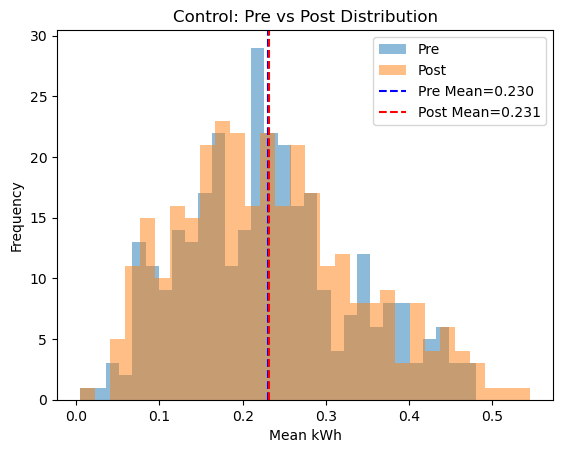

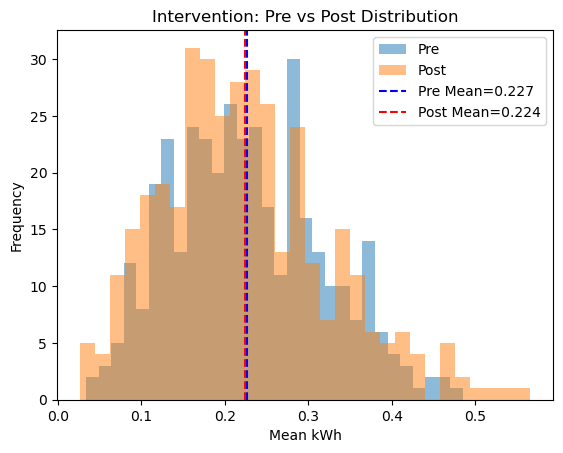

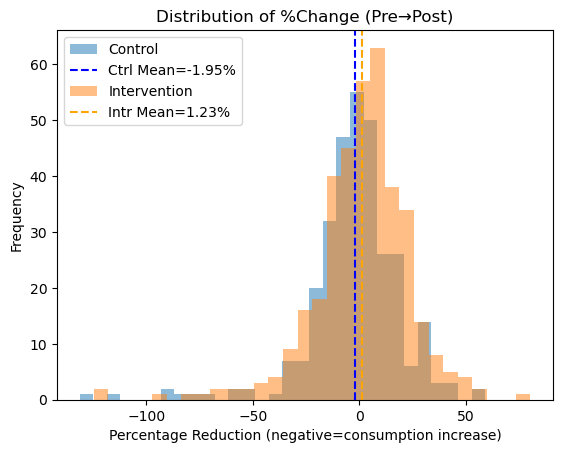


=== Paired T-test (Intervention): H0 => Post=Pre, H1 => Post<Pre ===
Mean diff=Post-Pre => -0.0032, t_stat=-1.2211, two-sided p=0.222828, one-sided p=0.111414
Conclusion (T-test): CANNOT reject H0 => No evidence that Post < Pre.

=== Wilcoxon signed-rank (Intervention): H0 => Post=Pre, H1 => Post<Pre ===
W-stat=29008.0000, two-sided p=0.006194, one-sided p=0.003097
Conclusion (Wilcoxon): REJECT H0 => Intervention's Post usage < Pre usage.


In [4]:
generate_intervention_analysis(
    include_time_of_day_start=16,
    include_time_of_day_end=19,
    exclude_time_of_day_start=None,
    exclude_time_of_day_end=None,
    pre_start=pd.Timestamp("2023-04-01 00:00:00"),
    pre_end=pd.Timestamp("2023-12-20 23:59:59"),
    post_start=pd.Timestamp("2024-04-01 00:00:00"),
    post_end=pd.Timestamp("2024-12-20 23:59:59"),
    lower_end_consumption=0,
    higher_end_consumption=97.5,
    file_path=r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"
)


[INFO] Processing controlePreConsolide.csv -> Min Time: 2023-02-02 00:00:00, Max Time: 2024-01-31 23:30:00
[INFO] Processing controleConsolide.csv -> Min Time: 2024-04-01 00:00:00, Max Time: 2024-12-31 23:30:00
[INFO] Processing interventionPreConsolide.csv -> Min Time: 2023-02-02 00:00:00, Max Time: 2024-01-31 23:30:00
[INFO] Processing interventionConsolide.csv -> Min Time: 2024-04-01 00:00:00, Max Time: 2024-12-31 23:30:00
[INFO] Full pivot shape => (705, 5)
[INFO] After trimming => 682 rows remain
[INFO] df_control shape=(308, 5), df_intervention shape=(374, 5)


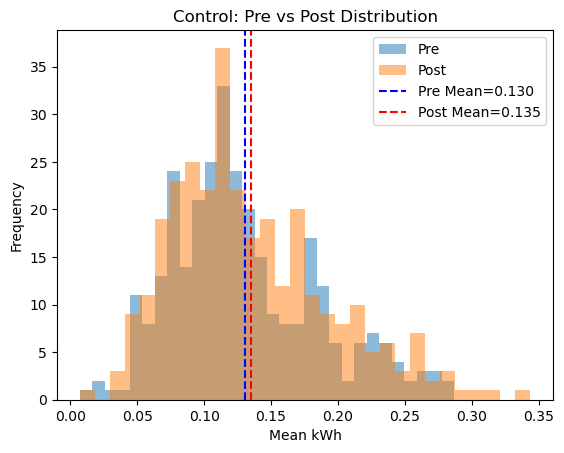

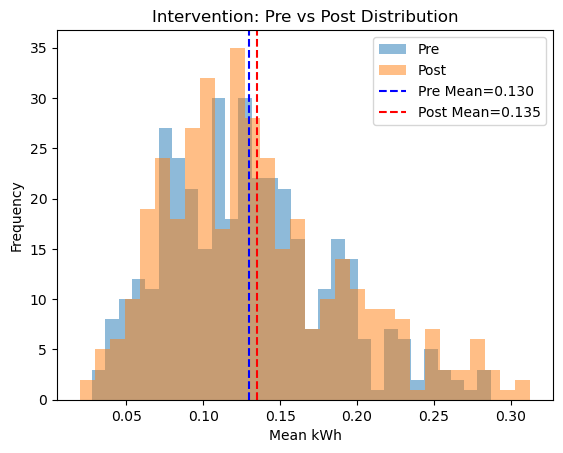

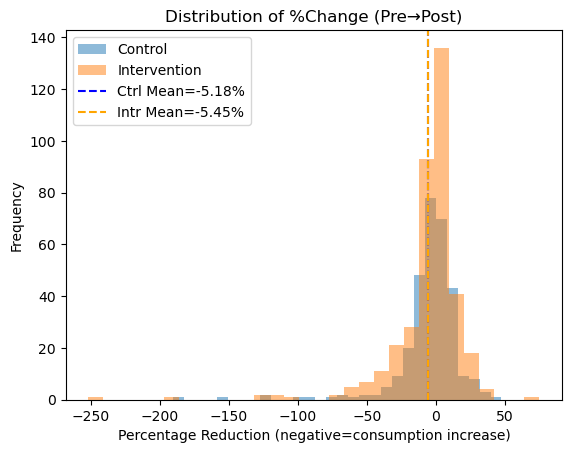


=== Paired T-test for Intervention: H0 => Post=Pre, H1 => Post<Pre ===
Intervention Pre mean=0.130, Post mean=0.135
Mean diff=Post-Pre => 0.0052
T-stat=3.6146, two-sided p=0.000342, one-sided p=0.999829
Conclusion: We CANNOT reject H0. No significant evidence that Intervention's Post usage is lower than Pre at alpha=0.05.


In [100]:
generate_intervention_analysis(
    include_time_of_day_start=0,
    include_time_of_day_end=24,
    exclude_time_of_day_start=16,
    exclude_time_of_day_end=19,
    pre_start=pd.Timestamp("2023-04-01 00:00:00"),
    pre_end=pd.Timestamp("2023-12-20 23:59:59"),
    post_start=pd.Timestamp("2024-04-01 00:00:00"),
    post_end=pd.Timestamp("2024-12-20 23:59:59"),
    lower_end_consumption=0,
    higher_end_consumption=97.5,
    file_path=r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"
)


In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.stats import ttest_rel, wilcoxon, norm

def generate_sunday_pre_post_analysis(
        time_of_day_start=0,
        time_of_day_end=24,
        pre_start=pd.Timestamp("2023-02-01 00:00:00"),
        pre_end=pd.Timestamp("2024-01-31 23:59:59"),
        post_start=pd.Timestamp("2024-04-01 00:00:00"),
        post_end=pd.Timestamp("2024-12-31 23:59:59"),
        lower_end_consumption=2.5,
        higher_end_consumption=97.5,
        illustrate_wilcoxon=False,    # <-- NEW: if True, simulate Wilcoxon distribution under H0
        nsim=20000,                  # Monte Carlo replicates for the Wilcoxon distribution
        file_path=r"C:\path\to\your\data"
    ):
    """
    Compare Pre vs. Post specifically on Sundays for both Control & Intervention,
    testing if Post usage is higher than Pre usage (H1: Post>Pre).
    If illustrate_wilcoxon=True, we also simulate the Wilcoxon T+ distribution under H0
    for each group and plot a histogram with the observed T+.

    Files:
      - Control Pre Sunday => "controlePreConsolide.csv" (which includes Mon–Sun, so we filter Sundays)
      - Control Post Sunday => "controleConsolideSunday.csv" (Sunday-only)
      - Intervention Pre Sunday => "interventionPreConsolide.csv" (Mon–Sun, filter Sundays)
      - Intervention Post Sunday => "interventionConsolideSunday.csv" (Sunday-only)

    Steps:
      1) Filter each file to Sunday, date/time range.
      2) Pivot => [Pre, Post] for each ANON_ID. 
      3) Paired T-test + Wilcoxon => H0: Post=Pre, H1: Post>Pre.
      4) If illustrate_wilcoxon=True, simulate T+ distribution under H0 and overlay the actual T+.

    Returns
    -------
    None
    """

    # ---------- Helper Functions ---------------------------------------------
    def read_pre_sunday(file_name, start_date, end_date):
        """Reads a 'Pre' file (which has Mon–Sun), keeps only Sunday & relevant hours."""
        df = pd.read_csv(os.path.join(file_path, file_name))
        df = df.rename(columns={'Unnamed: 0': 'Time'})
        df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S")

        print(f"[INFO] Pre Sunday file: {file_name} => min={df['Time'].min()}, max={df['Time'].max()}")

        df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]
        df = df[df['Time'].dt.weekday == 6]  # Sunday => weekday==6
        df = df[
            (df['Time'].dt.hour >= time_of_day_start) &
            (df['Time'].dt.hour <  time_of_day_end)
        ]

        df_long = df.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')
        df_long.drop_duplicates(subset=['Time','ANON_ID'], inplace=True)
        df_agg = df_long.groupby('ANON_ID', as_index=False)['ELEC_KWH'].mean()
        return df_agg

    def read_post_sunday(file_name, start_date, end_date):
        """Reads a 'Post' Sunday file, which is already Sunday-only data, and filters by date/time-of-day."""
        df = pd.read_csv(os.path.join(file_path, file_name))
        df = df.rename(columns={'Unnamed: 0': 'Time'})
        df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S")

        print(f"[INFO] Post Sunday file: {file_name} => min={df['Time'].min()}, max={df['Time'].max()}")

        df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]
        df = df[
            (df['Time'].dt.hour >= time_of_day_start) &
            (df['Time'].dt.hour <  time_of_day_end)
        ]

        df_long = df.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')
        df_long.drop_duplicates(subset=['Time','ANON_ID'], inplace=True)
        df_agg = df_long.groupby('ANON_ID', as_index=False)['ELEC_KWH'].mean()
        return df_agg

    # ---------- Wilcoxon simulation under H0 (mean diff=0) -------------------
    def simulate_wilcoxon_distribution(n, nsim=20000, seed=42):
        """
        Monte Carlo approach: generate n diffs ~ N(0,1) => compute T+ each time => plot distribution.
        Returns the array of T+ values for optional usage.
        """
        np.random.seed(seed)
        wstats = []
        for _ in range(nsim):
            diffs = np.random.normal(loc=0.0, scale=1.0, size=n)
            if np.allclose(diffs, 0.0):
                continue
            Tplus, _ = wilcoxon(diffs)
            wstats.append(Tplus)
        return np.array(wstats)

    # -------------------------------------------------------------------------
    # 1) Read data for each group (Pre Sunday, Post Sunday)
    # -------------------------------------------------------------------------
    ctrl_pre_sun  = read_pre_sunday("controlePreConsolide.csv", pre_start, pre_end)
    ctrl_pre_sun['Group'] = 'Control';    ctrl_pre_sun['Phase'] = 'Pre'

    ctrl_post_sun = read_post_sunday("controleConsolideSunday.csv", post_start, post_end)
    ctrl_post_sun['Group'] = 'Control';   ctrl_post_sun['Phase'] = 'Post'

    intr_pre_sun  = read_pre_sunday("interventionPreConsolide.csv", pre_start, pre_end)
    intr_pre_sun['Group'] = 'Intervention'; intr_pre_sun['Phase']='Pre'

    intr_post_sun = read_post_sunday("interventionConsolideSunday.csv", post_start, post_end)
    intr_post_sun['Group'] = 'Intervention'; intr_post_sun['Phase']='Post'

    # Combine
    df_combined = pd.concat([
        ctrl_pre_sun, ctrl_post_sun,
        intr_pre_sun, intr_post_sun
    ], ignore_index=True)

    # 2) Pivot => columns [Pre, Post], one row per ANON_ID+Group
    df_mean = df_combined.groupby(['ANON_ID','Group','Phase'], as_index=False)['ELEC_KWH'].mean()
    df_pivot = df_mean.pivot(index=['ANON_ID','Group'], columns='Phase', values='ELEC_KWH').reset_index()
    df_pivot.dropna(subset=['Pre','Post'], inplace=True)

    # 3) Trim outliers
    pre_lower = np.percentile(df_pivot['Pre'],  lower_end_consumption)
    pre_upper = np.percentile(df_pivot['Pre'],  higher_end_consumption)
    post_lower= np.percentile(df_pivot['Post'], lower_end_consumption)
    post_upper= np.percentile(df_pivot['Post'], higher_end_consumption)

    df_trim = df_pivot[
        (df_pivot['Pre']  >= pre_lower) & (df_pivot['Pre']  <= pre_upper) &
        (df_pivot['Post'] >= post_lower)& (df_pivot['Post'] <= post_upper)
    ].copy()

    print(f"[INFO] After trimming => {df_trim.shape[0]} matched rows remain")

    # 4) Separate Control vs. Intervention
    df_control = df_trim[df_trim['Group']=='Control'].copy()
    df_intern  = df_trim[df_trim['Group']=='Intervention'].copy()

    cpre_mean = df_control['Pre'].mean()  if len(df_control)>0 else np.nan
    cpost_mean= df_control['Post'].mean() if len(df_control)>0 else np.nan
    ipre_mean = df_intern['Pre'].mean()   if len(df_intern)>0 else np.nan
    ipost_mean= df_intern['Post'].mean()  if len(df_intern)>0 else np.nan

    # 5) Plot: Control Sunday Pre vs Post
    plt.figure()
    if len(df_control)>0:
        plt.hist(df_control['Pre'], bins=30, alpha=0.5, label='Pre')
        plt.hist(df_control['Post'], bins=30, alpha=0.5, label='Post')
        plt.axvline(cpre_mean,  color='blue', linestyle='--', label=f"Pre Mean={cpre_mean:.3f}")
        plt.axvline(cpost_mean, color='red',  linestyle='--', label=f"Post Mean={cpost_mean:.3f}")
    plt.title("Control Sunday: Pre vs Post")
    plt.xlabel("Mean kWh (Sunday)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 6) Plot: Intervention Sunday Pre vs Post
    plt.figure()
    if len(df_intern)>0:
        plt.hist(df_intern['Pre'],  bins=30, alpha=0.5, label='Pre')
        plt.hist(df_intern['Post'], bins=30, alpha=0.5, label='Post')
        plt.axvline(ipre_mean,   color='blue',  linestyle='--', label=f"Pre Mean={ipre_mean:.3f}")
        plt.axvline(ipost_mean,  color='red',   linestyle='--', label=f"Post Mean={ipost_mean:.3f}")
    plt.title("Intervention Sunday: Pre vs Post")
    plt.xlabel("Mean kWh (Sunday)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 7) Tests: Paired T-test + Wilcoxon => H1 => Post>Pre
    alpha=0.05

    for group_name, df_grp in [('Control', df_control), ('Intervention', df_intern)]:
        print(f"\n=== {group_name} Sunday: Paired T-test & Wilcoxon => H1 => Post>Pre ===")
        n = len(df_grp)
        if n<2:
            print("[WARN] Not enough matched pairs for a paired test.")
            continue

        df_grp['diff'] = df_grp['Post'] - df_grp['Pre']
        mean_diff = df_grp['diff'].mean()

        # (A) Paired T-test
        t_stat, p_twoside_t = ttest_rel(df_grp['Post'], df_grp['Pre'])
        if mean_diff>0:
            p_oneside_t = p_twoside_t/2
        else:
            p_oneside_t = 1 - (p_twoside_t/2)

        print(f"[T-test] mean_diff=Post-Pre => {mean_diff:.4f}, t_stat={t_stat:.4f}, two-sided p={p_twoside_t:.6f}, one-sided p={p_oneside_t:.6f}")
        if p_oneside_t<alpha and mean_diff>0:
            print("Conclusion (T-test): REJECT H0 => Post>Pre.")
        else:
            print("Conclusion (T-test): No evidence Post>Pre.")

        # (B) Wilcoxon
        # By default, 'wilcoxon(x, y=None)' => T+ for x
        Tplus, p_twoside_w = wilcoxon(df_grp['Post'], df_grp['Pre'])
        if mean_diff>0:
            p_oneside_w = p_twoside_w/2
        else:
            p_oneside_w = 1 - (p_twoside_w/2)

        print(f"[Wilcoxon] T+={Tplus:.4f}, two-sided p={p_twoside_w:.6f}, one-sided p={p_oneside_w:.6f}")
        if p_oneside_w<alpha and mean_diff>0:
            print("Conclusion (Wilcoxon): REJECT H0 => Post>Pre.")
        else:
            print("Conclusion (Wilcoxon): No evidence Post>Pre.")

        # --- If user requested illustration of Wilcoxon distribution under H0
        if illustrate_wilcoxon and n>=2:
            simulate_and_plot_wilcoxon(df_grp, Tplus, n, nsim)


def simulate_and_plot_wilcoxon(df_grp, observed_Tplus, n, nsim=20000):
    """
    Called inside generate_sunday_pre_post_analysis if illustrate_wilcoxon=True.
    We'll simulate T+ under H0 =>  diffs ~ N(0,1). Then plot distribution
    with a vertical line for the observed T+ in 'observed_Tplus'.
    """
    # 1) Simulate T+ for n diffs under H0
    wstats = []
    np.random.seed(42)
    for _ in range(nsim):
        diffs = np.random.normal(0.0, 1.0, n)
        # skip if all zero
        if np.allclose(diffs, 0):
            continue
        Tplus_sim, _ = wilcoxon(diffs)
        wstats.append(Tplus_sim)
    wstats = np.array(wstats)

    # 2) Plot histogram
    plt.figure(figsize=(8,5))
    plt.hist(wstats, bins=30, alpha=0.5, density=True, label='Simulated T+ (H0)')

    # 3) Normal approximation overlay
    # Under H0 for Wilcoxon signed-rank, T+ ~ mean=n(n+1)/4, var=n(n+1)(2n+1)/24
    mean_approx = n*(n+1)/4.0
    var_approx  = n*(n+1)*(2*n+1)/24.0
    std_approx  = np.sqrt(var_approx)
    x = np.linspace(0, n*(n+1)/2, 400)
    pdf_approx  = norm.pdf(x, loc=mean_approx, scale=std_approx)
    plt.plot(x, pdf_approx, 'r-', alpha=0.6, label='Normal approx')

    # 4) Vertical line for observed T+
    plt.axvline(observed_Tplus, color='orange', linestyle='--', label=f"Observed T+={observed_Tplus:.1f}")

    plt.title(f"Wilcoxon T+ Distribution under H0 (n={n})\nObserved T+={observed_Tplus:.1f}")
    plt.xlabel("T+")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


[INFO] Pre Sunday file: controlePreConsolide.csv => min=2023-02-02 00:00:00, max=2024-01-31 23:30:00
[INFO] Post Sunday file: controleConsolideSunday.csv => min=2024-04-07 00:00:00, max=2024-12-29 23:30:00
[INFO] Pre Sunday file: interventionPreConsolide.csv => min=2023-02-02 00:00:00, max=2024-01-31 23:30:00
[INFO] Post Sunday file: interventionConsolideSunday.csv => min=2024-04-07 00:00:00, max=2024-12-29 23:30:00
[INFO] After trimming => 648 matched rows remain


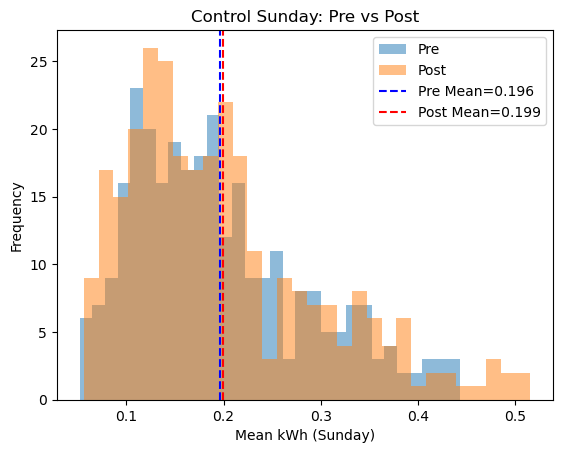

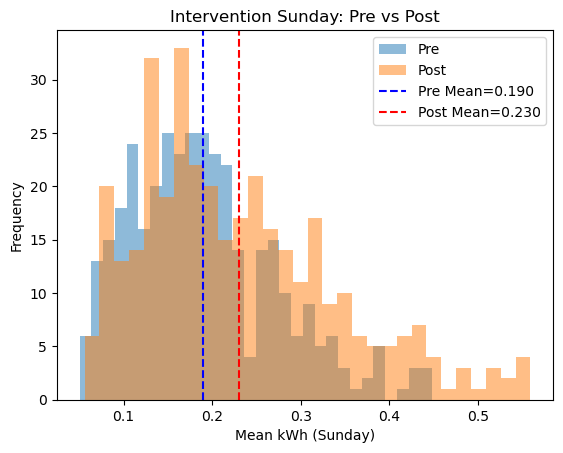


=== Control Sunday: Paired T-test & Wilcoxon => H1 => Post>Pre ===
[T-test] mean_diff=Post-Pre => 0.0030, t_stat=1.0779, two-sided p=0.281975, one-sided p=0.140987
Conclusion (T-test): No evidence Post>Pre.
[Wilcoxon] T+=20606.0000, two-sided p=0.587677, one-sided p=0.293838
Conclusion (Wilcoxon): No evidence Post>Pre.


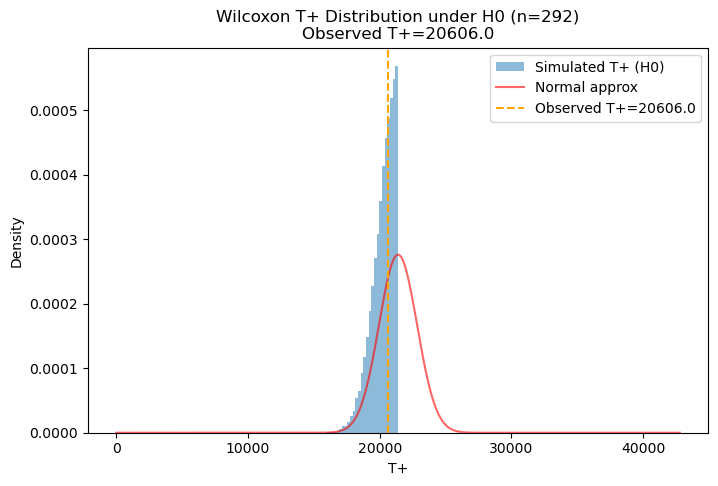


=== Intervention Sunday: Paired T-test & Wilcoxon => H1 => Post>Pre ===
[T-test] mean_diff=Post-Pre => 0.0398, t_stat=9.6028, two-sided p=0.000000, one-sided p=0.000000
Conclusion (T-test): REJECT H0 => Post>Pre.
[Wilcoxon] T+=13593.0000, two-sided p=0.000000, one-sided p=0.000000
Conclusion (Wilcoxon): REJECT H0 => Post>Pre.


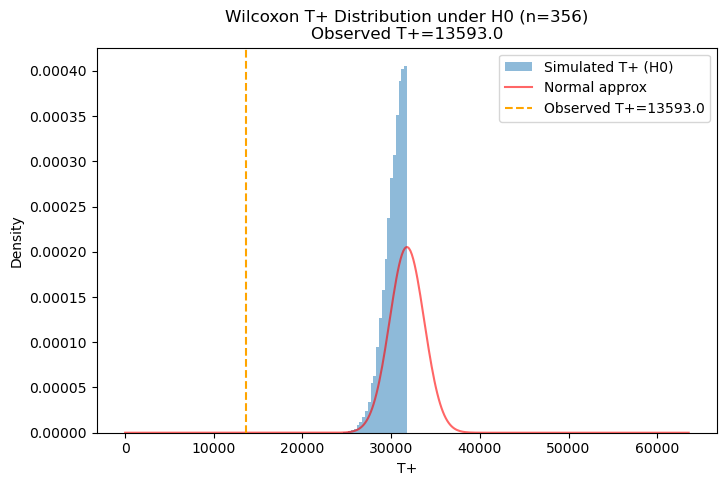

In [16]:

generate_sunday_pre_post_analysis(
    time_of_day_start=8,
    time_of_day_end=12,
    pre_start=pd.Timestamp("2023-02-01 00:00:00"),
    pre_end=pd.Timestamp("2024-01-31 23:59:59"),
    post_start=pd.Timestamp("2024-04-01 00:00:00"),
    post_end=pd.Timestamp("2024-12-31 23:59:59"),
    lower_end_consumption=2.5,
    higher_end_consumption=97.5,
    illustrate_wilcoxon=True,    # if True, simulate Wilcoxon distribution under H0
    nsim=20000,    
    file_path=r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"
)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, norm

def illustrate_wilcoxon_distribution(n=15, nsim=20000, mu_diff=0.0, seed=42):
    """
    Simulate data under H0 (mu_diff=0) for a paired scenario.
    For each simulated dataset, compute the Wilcoxon signed-rank statistic.
    Then plot the distribution of that statistic.
    
    Parameters
    ----------
    n : int
        Sample size (number of pairs).
    nsim : int
        Number of Monte Carlo replicates.
    mu_diff : float
        Mean difference under the alternative. Set to 0 for H0.
    seed : int
        Random seed for reproducibility.
    """
    np.random.seed(seed)
    
    # We'll store the Wilcoxon statistic (T+ or T-).
    # By default, scipy.stats.wilcoxon returns the sum of ranks of positive differences (T+).
    # We collect those and see how they vary under H0 or mu_diff != 0.
    wstats = []
    
    for _ in range(nsim):
        # Generate n differences from a normal with mean=mu_diff (0 => H0)
        # There's no essential restriction that it be normal, but let's do so for demonstration
        diffs = np.random.normal(loc=mu_diff, scale=1.0, size=n)

        # If all diffs are 0, Wilcoxon returns a degenerate result
        # We'll skip that replicate
        if np.allclose(diffs, 0.0):
            continue

        # Compute the Wilcoxon signed-rank test statistic
        # By default, wilcoxon(x,y=None) => a one-sample signed-rank test
        # returning (T+, pvalue).
        Tplus, _ = wilcoxon(diffs)
        wstats.append(Tplus)
    
    wstats = np.array(wstats)
    
    # 1) Plot the histogram of T+ values
    plt.figure(figsize=(8,5))
    plt.hist(wstats, bins=30, alpha=0.5, density=True, label='Simulated T+')
    
    # 2) For large n, T+ ~ normal with mean = n(n+1)/4, var = n(n+1)(2n+1)/24
    # Let's overlay that normal approximation if n is large enough
    mean_approx = n*(n+1)/4.0
    var_approx  = n*(n+1)*(2*n+1)/24.0
    std_approx  = np.sqrt(var_approx)

    # x-range for the normal approximation
    x = np.linspace(0, n*(n+1)/2.0, 500)
    y = norm.pdf(x, loc=mean_approx, scale=std_approx)
    plt.plot(x, y, 'r-', label='Normal approx', alpha=0.7)
    
    plt.title(f"Wilcoxon Signed-Rank Distribution (n={n}, mu_diff={mu_diff}, nsim={nsim})")
    plt.xlabel("T+ (sum of positive ranks)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


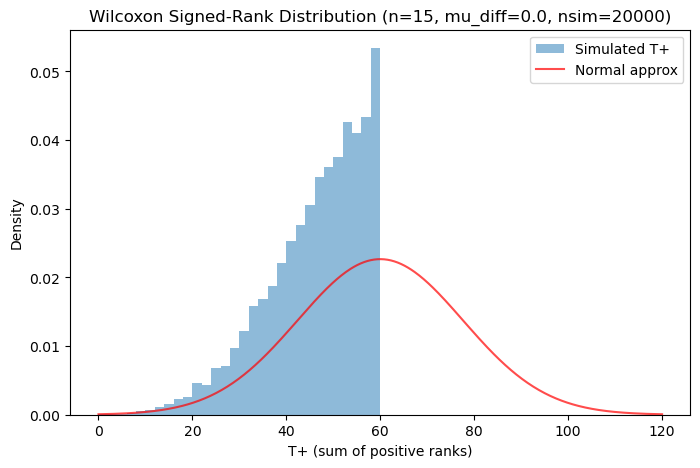

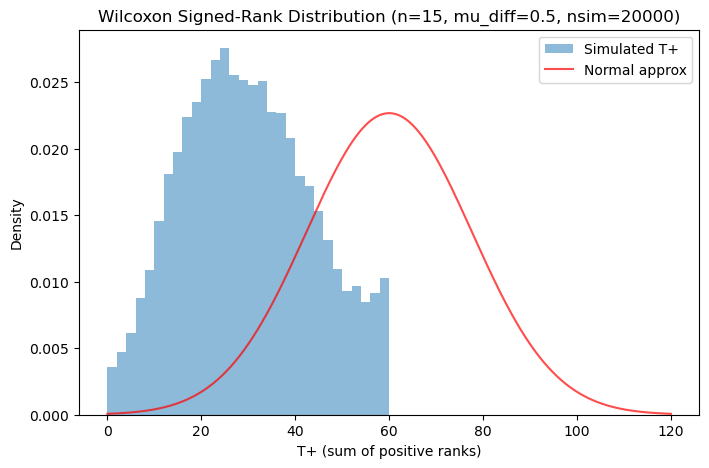

In [14]:
# Example: Under the null hypothesis => mu_diff=0
illustrate_wilcoxon_distribution(n=15, nsim=20000, mu_diff=0.0)

# Or to see how it shifts if there's a positive difference
illustrate_wilcoxon_distribution(n=15, nsim=20000, mu_diff=0.5)


# IGNORE REST

In [13]:
file_name = r"\controlePreConsolide.csv"
csv_path = file_path + file_name
df_control_Pre_Consolide = pd.read_csv(csv_path)

In [14]:
file_name = r"\interventionConsolide.csv"
csv_path = file_path + file_name
df_intervention_Consolide = pd.read_csv(csv_path)

In [15]:
file_name = r"\interventionConsolideSunday.csv"
csv_path = file_path + file_name
df_intervention_Consolide_Sunday = pd.read_csv(csv_path)

In [16]:
file_name = r"\interventionPreConsolide.csv"
csv_path = file_path + file_name
df_intervention_Pre_Consolide = pd.read_csv(csv_path)

In [17]:
file_name = r"\socioEcodata.csv"
csv_path = file_path + file_name
df_socio = pd.read_csv(csv_path)

## Generic Data comments:
1. Socioeconomic info for 1138 ANON_IDs with a total of 18 columns
2. ControlConsolide has 11420 half-hour readings for 506 ANON_IDs
3. Socioeconomic has no repeated features nor ANON_IDs
4. In ControlConsolide, 487 / 506 ANON_IDs dhave socioeconomic features
5. The timeframe of ControlConsolide is 2024-04-01 to 2024-12-31


In [12]:

df_socio_c = df_socio.columns
print(df_socio_c)


Index(['HASH_KEY', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
       'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
       'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
       'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
       'TARIFF_GROUP', 'ESTIMATED_CONSUMPTION_ELEC_DAY',
       'ESTIMATED_CONSUMPTION_ELEC_NIGHT', 'ESTIMATED_CONSUMPTION_TOTAL'],
      dtype='object')


### Control 
Time frame: 2024-04-01 to 2024-12-31
Shape: (11420, 507)
Common ground: 487 / 506

### Control Sunday
Time frame: 2024-04-07 - 2024-12-31
Shape: (1872, 504)
Common ground: 487 / 503

## Pre Control
Time frame: 2023-02-02 - 2024-01-31
Shape: (17314, 321)
Common ground: 313 / 320

### Intervention
Time frame:  2024-04-01 - 2024-12-31
Shape: (11308, 667)
Common ground: 644 / 666

### Intervention Sunday
Time frame:  2024-04-07 - 2024-12-31
Shape: (1872, 664)
Common ground: 643 / 663

### Pre Intervention  
Time frame:   2023-02-02 - 2024-01-31
Shape: (17371, 388)
Common ground: 372 / 387



In [10]:
df = df_control_Consolide 
print(df.shape)
cols_df = df.columns

print(df.head())
print(df.tail())
common_keys_df = df_socio['HASH_KEY'].isin(cols_df)
print(f"Number of matching entries: {common_keys_df.sum()}")

df = df.rename(columns={'Unnamed: 0': 'Time'})
df['Time'] = pd.to_datetime(df['Time'])

# Unpivot (melt) the dataset: Convert wide format to long format
df_long = df.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')
df_long['Month'] = df_long['Time'].dt.month
df_long['DayOfWeek'] = df_long['Time'].dt.day_name()
df_long['HalfHour'] = df_long['Time'].dt.strftime('%H:%M')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count occurrences per (Month, DayOfWeek)
entries_count = df_long.groupby(['DayOfWeek', 'Month']).size().unstack()
entries_count = entries_count.reindex(day_order)
entries_count = entries_count.fillna(0).astype(int)



(11420, 507)
            Unnamed: 0  \
0  2024-04-01 00:00:00   
1  2024-04-01 00:30:00   
2  2024-04-01 01:00:00   
3  2024-04-01 01:30:00   
4  2024-04-01 02:00:00   

   8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9c09ed798b4262b0c1c  \
0                                              0.020                  
1                                              0.063                  
2                                              0.047                  
3                                              0.015                  
4                                              0.051                  

   ba0094d2fc8a6a5f53ac93dbe2ebea54077fe5d2dc594254669bdabf72ac600c  \
0                                              0.083                  
1                                              0.095                  
2                                              0.088                  
3                                              0.076                  
4                                              0

In [11]:
df_long


,Time,ANON_ID,ELEC_KWH,Month,DayOfWeek,HalfHour
0,2024-04-01 00:00:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.020,4,Monday,00:00
1,2024-04-01 00:30:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.063,4,Monday,00:30
2,2024-04-01 01:00:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.047,4,Monday,01:00
3,2024-04-01 01:30:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.015,4,Monday,01:30
4,2024-04-01 02:00:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.051,4,Monday,02:00
...,...,...,...,...,...,...
5778515,2024-12-31 21:30:00,ccda3cf02d63eb6357954d94acc8aae83535124d286085...,0.203,12,Tuesday,21:30
5778516,2024-12-31 22:00:00,ccda3cf02d63eb6357954d94acc8aae83535124d286085...,0.213,12,Tuesday,22:00
5778517,2024-12-31 22:30:00,ccda3cf02d63eb6357954d94acc8aae83535124d286085...,0.225,12,Tuesday,22:30
5778518,2024-12-31 23:00:00,ccda3cf02d63eb6357954d94acc8aae83535124d286085...,0.192,12,Tuesday,23:00


In [56]:
df_socio.columns

Index(['HASH_KEY', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
       'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
       'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
       'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
       'TARIFF_GROUP', 'ESTIMATED_CONSUMPTION_ELEC_DAY',
       'ESTIMATED_CONSUMPTION_ELEC_NIGHT', 'ESTIMATED_CONSUMPTION_TOTAL'],
      dtype='object')

In [58]:
df_socio.head()

,HASH_KEY,AGE_GROUP,INCOME_CATEGORY,HOUSEHOLD_OCCUPANCY,CHILDREN_AT_HOME,HOUSEHOLD_SIZE,NUMBER_OF_BEDROOMS,OCCUPATION,EMPLOYMENT_STATUS,HIGHEST_QUALIFICATION,HOME_OWNERSHIP,HOME_TYPE,HOME_VALUE,SOCIAL_GRADE,TARIFF_GROUP,ESTIMATED_CONSUMPTION_ELEC_DAY,ESTIMATED_CONSUMPTION_ELEC_NIGHT,ESTIMATED_CONSUMPTION_TOTAL
0,8399087eaac9d88e3c6fce0c76484d18a40576c2fd46b7...,35-44,"50,000-74,999",Couple Household,0,2,3,Professional,Employed,University Degree or Higher,Owner Occupied,Semi-Detached House,250-500k,Social grade B,Deemed,2088,0,2088
1,b2d78d29b401e989873368a90f4079ba17bf5448db4c73...,65-74,"30,000-39,999",Couple Household,0,2,3,Retired,Not Employed,A Level Equivalent,Owner Occupied,Semi-Detached House,250-500k,Social grade C1,EDF Essentials,2422,0,2422
2,dc1ec3fca1531822856b50fabe334a17a6053dccb66498...,55-64,"0-9,999",Single Adult Household,0,1,1,Director/Managerial,Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,Safeguard Assist,1374,0,1374
3,cd68542ea1a700c995074c15c8f41973443359a9bbff2a...,75+,"20,000-29,999",Single Adult Household,0,1,1,Retired,Not Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,EDF Essentials,2619,0,2619
4,fef90b0143496f6e158ba9db416049340d590648659fc6...,55-64,"100,000+",Couple Household,0,2,4,Professional,Employed,University Degree or Higher,Owner Occupied,Detached House,250-500k,Social grade B,Standard,5504,0,5504


In [62]:
common_keys = df_socio['HASH_KEY'].isin(cols_control_consolide)
print(f"Number of matching entries: {common_keys.sum()}")

Number of matching entries: 487


In [64]:
# Count the number of duplicate HASH_KEY values
duplicate_counts = df_socio['HASH_KEY'].duplicated().sum()
print(f"Number of duplicate HASH_KEY entries: {duplicate_counts}")

Number of duplicate HASH_KEY entries: 0


In [70]:
# Get all column names from df_control_Consolide
cols_control_consolide = set(df_control_Consolide.columns)

# Check which columns are NOT in df_socio['HASH_KEY']
missing_cols = cols_control_consolide - set(df_socio['HASH_KEY'])

print("Columns in df_control_Consolide that are NOT in df_socio['HASH_KEY']:")
print(missing_cols)


Columns in df_control_Consolide that are NOT in df_socio['HASH_KEY']:
{'974b62dc16b47fde35954aa89d621c6b059df2f8ecb0ff463bd8421decfe2b4b', '31997152c8a481c326d6cb05abbd7690403eaf513945e1aba3279f31d344c956', '6dde0e5269f557dc5530f5107a9ad925b7fafc6a52d4f6fef834a0e23fd8b63c', 'f2848aa492c813342866756de0da956026d4331e105b16f881357cae62dae2c1', 'ab48a3a3cca4eedbb8d6317c4e02de2523ecaa866117a0672aa989fa830ba52a', 'e06665e30bb8bb901086cebe613ee5e64c2750c5b847281760cbf6754a75e66c', 'cef4e134e06416be90396291d8a37128906c0bf249ef71d696a4f0b22d3cffde', 'd4a27dd49c8bf8270dff2411f456287af4ad6d0fd86889506362b9fd13f86e87', '018e0c5cf686da1b7ac2d170d54aba9263fdc420b65ff5e71d4539e926385772', 'f4c3bcbc7dd37e40f8f6238c94fd99b4e488f7ec07f54dbd53849f23d0c34e1f', '1e1bfa63fff199a44b7b248c11265dd721b33f1d2edc7e9fae9f714bbba78564', 'Unnamed: 0', 'bbd37f115949e74f97d7fbb407e3ed505bc179507d744340dace2d71a5813950', '0a67e7537bf618ab4f6983665d02d2cba69773971926d22c411678814d730ff0', '585675d4b905182ed7cee11a72597a

# EDA

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Average ELEC_KWH')

Text(0.5, 1.0, 'Average Electricity Consumption per Month')

([<matplotlib.axis.XTick at 0x187ad835760>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

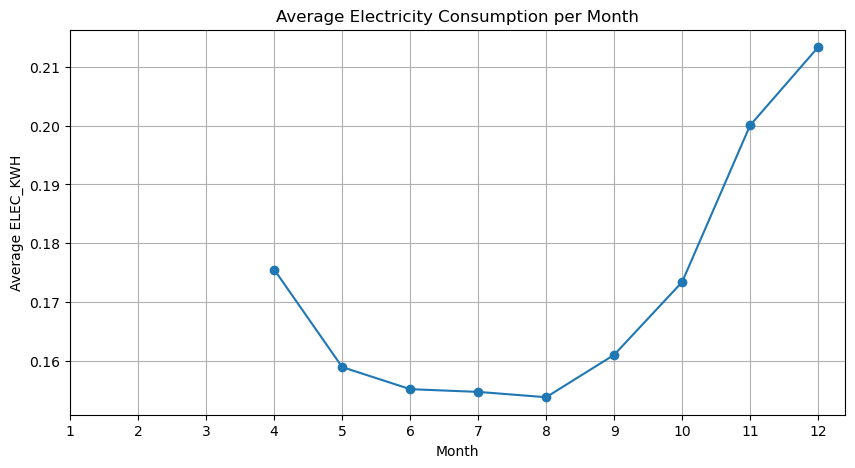

<Figure size 1500x600 with 0 Axes>

<Axes: xlabel='HalfHour', ylabel='ELEC_KWH'>

Text(0.5, 0, 'Half-Hour Time Slot')

Text(0, 0.5, 'Average Electricity Consumption (ELEC_KWH)')

Text(0.5, 1.0, 'Average Electricity Consumption per Half-Hour by Day of the Week')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 [Text(0, 0, '00:00'),
  Text(1, 0, '00:30'),
  Text(2, 0, '01:00'),
  Text(3, 0, '01:30'),
  Text(4, 0, '02:00'),
  Text(5, 0, '02:30'),
  Text(6, 0, '03:00'),
  Text(7, 0, '03:30'),
  Text(8, 0, '04:00'),
  Text(9, 0, '04:30'),
  Text(10, 0, '05:00'),
  Text(11, 0, '05:30'),
  Text(12, 0, '06:00'),
  Text(13, 0, '06:30'),
  Text(14, 0, '07:00'),
  Text(15, 0, '07:30'),
  Text(16, 0, '08:00'),
  Text(17, 0, '08:30'),
  Text(18, 0, '09:00'),
  Text(19, 0, '09:30'),
  Text(20, 0, '10:00'),
  Text(21, 0, '10:30'),
  Text(22, 0, '11:00'),
  Text(23, 0, '11:30'),
  Text(24, 0, '12:00'),
  Text(25, 0, '12:30'),
  Text(26, 0, '13:00'),
  Text(27, 0, '13:30'),
  Text(28, 0, '14:00'),
  Text(29, 0, '14:30'),
  Text(30, 

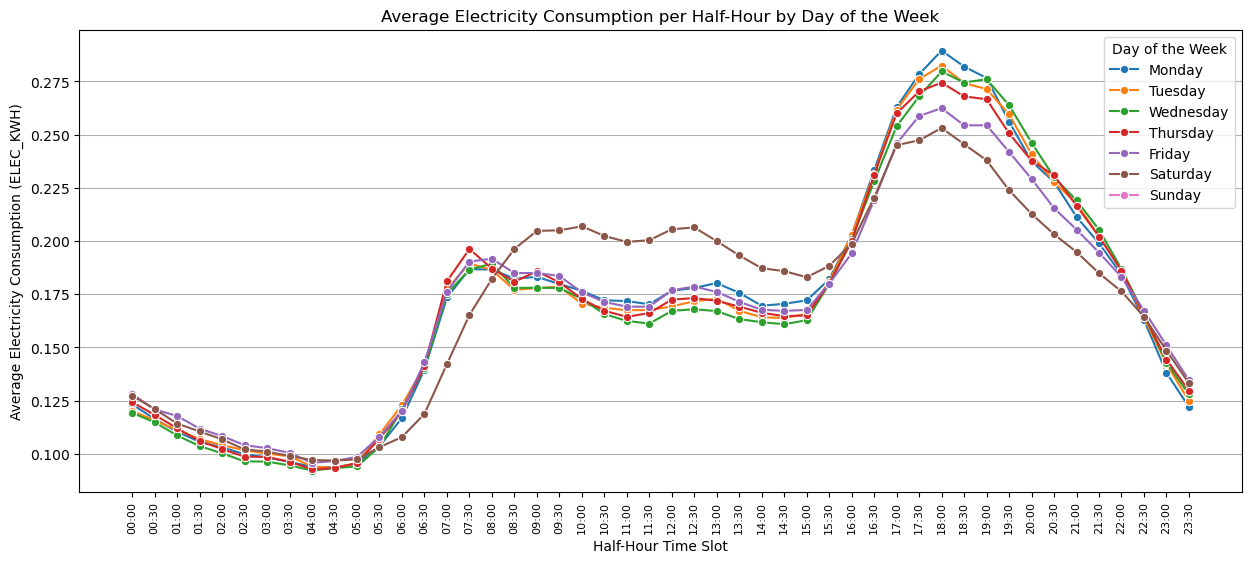

<Figure size 1500x600 with 0 Axes>

<Axes: title={'center': 'ELEC_KWH'}, xlabel='HalfHour'>

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 [Text(1, 0, '00:00'),
  Text(2, 0, '00:30'),
  Text(3, 0, '01:00'),
  Text(4, 0, '01:30'),
  Text(5, 0, '02:00'),
  Text(6, 0, '02:30'),
  Text(7, 0, '03:00'),
  Text(8, 0, '03:30'),
  Text(9, 0, '04:00'),
  Text(10, 0, '04:30'),
  Text(11, 0, '05:00'),
  Text(12, 0, '05:30'),
  Text(13, 0, '06:00'),
  Text(14, 0, '06:30'),
  Text(15, 0, '07:00'),
  Text(16, 0, '07:30'),
  Text(17, 0, '08:00'),
  Text(18, 0, '08:30'),
  Text(19, 0, '09:00'),
  Text(20, 0, '09:30'),
  Text(21, 0, '10:00'),
  Text(22, 0, '10:30'),
  Text(23, 0, '11:00'),
  Text(24, 0, '11:30'),
  Text(25, 0, '12:00'),
  Text(26, 0, '12:30'),
  Text(27, 0, '13:00'),
  Text(28, 0, '13:30'),
  Text(29, 0, '14:00'),
  Text(30, 0, '14:30'),
  Text(31, 0, '15:00'),
  Text(32, 0, '15:30'),
  Text(33, 0, '16:00'),

Text(0.5, 0, 'Half-Hour Time Slot')

Text(0, 0.5, 'ELEC_KWH')

Text(0.5, 1.0, 'Electricity Consumption Box Plot (Half-Hourly)')

Text(0.5, 0.98, '')

<Figure size 1500x600 with 0 Axes>

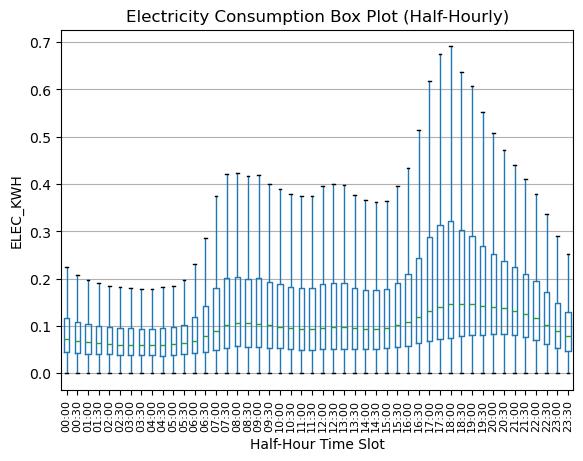

In [120]:
df_control_Consolide = df_control_Consolide.rename(columns={'Unnamed: 0': 'Time'})
df_control_Consolide['Time'] = pd.to_datetime(df_control_Consolide['Time'])

# Unpivot (melt) the dataset: Convert wide format to long format
df_control_Consolide_long = df_control_Consolide.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')
df_control_Consolide_long['Month'] = df_control_Consolide_long['Time'].dt.month
df_control_Consolide_long['DayOfWeek'] = df_control_Consolide_long['Time'].dt.day_name()
df_control_Consolide_long['HalfHour'] = df_control_Consolide_long['Time'].dt.strftime('%H:%M')  # Captures half-hourly reading format


## 1. Plot: Average Consumption Across Months
monthly_avg = df_control_Consolide_long.groupby('Month')['ELEC_KWH'].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average ELEC_KWH')
plt.title('Average Electricity Consumption per Month')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


# Compute the average ELEC_KWH for each HalfHour and DayOfWeek across all ANON_IDs
df_avg_halfhour = df_control_Consolide_long.groupby(['HalfHour', 'DayOfWeek'])['ELEC_KWH'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_avg_halfhour['DayOfWeek'] = pd.Categorical(df_avg_halfhour['DayOfWeek'], categories=day_order, ordered=True)

# Plot: Line chart for average electricity consumption per half-hour slot, with each line representing a day of the week
plt.figure(figsize=(15,6))
sns.lineplot(data=df_avg_halfhour, x="HalfHour", y="ELEC_KWH", hue="DayOfWeek", marker="o")
plt.xlabel("Half-Hour Time Slot")
plt.ylabel("Average Electricity Consumption (ELEC_KWH)")
plt.title("Average Electricity Consumption per Half-Hour by Day of the Week")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Day of the Week", bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.show()

## 3 Boxplot: Consumption Across Half-Hour Intervals Over the Year
plt.figure(figsize=(15,6))
df_control_Consolide_long.boxplot(column='ELEC_KWH', by='HalfHour', grid=False, showfliers=False)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Half-Hour Time Slot')
plt.ylabel('ELEC_KWH')
plt.title('Electricity Consumption Box Plot (Half-Hourly)')
plt.suptitle('')  # Remove default boxplot title
plt.grid(axis='y')
plt.show()


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Month', ylabel='DayOfWeek'>

Text(0.5, 36.72222222222221, 'Month')

Text(120.72222222222221, 0.5, 'Day of the Week')

Text(0.5, 1.0, 'Number of Entries per Day of the Week and Month')

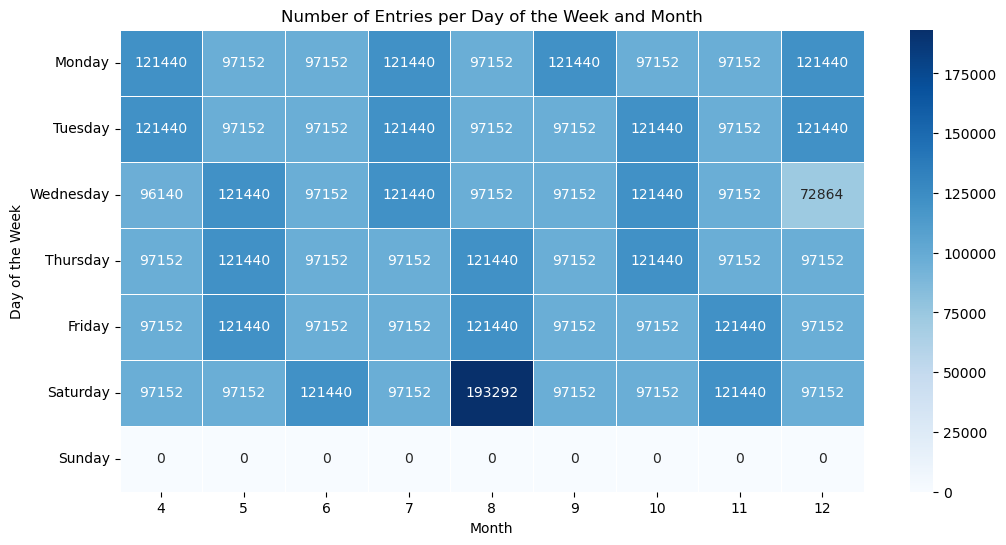

In [121]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count occurrences per (Month, DayOfWeek)
entries_count = df_control_Consolide_long.groupby(['DayOfWeek', 'Month']).size().unstack()
entries_count = entries_count.reindex(day_order)
entries_count = entries_count.fillna(0).astype(int)

plt.figure(figsize=(12,6))
sns.heatmap(entries_count, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Month")
plt.ylabel("Day of the Week")
plt.title("Number of Entries per Day of the Week and Month")
plt.show()



                    Time DayOfWeek  EntryCount  UniqueHouseholds
0    2024-08-01 00:00:00  Thursday         506               506
1    2024-08-01 00:30:00  Thursday         506               506
2    2024-08-01 01:00:00  Thursday         506               506
3    2024-08-01 01:30:00  Thursday         506               506
4    2024-08-01 02:00:00  Thursday         506               506
...                  ...       ...         ...               ...
1291 2024-08-31 21:30:00  Saturday         506               506
1292 2024-08-31 22:00:00  Saturday         506               506
1293 2024-08-31 22:30:00  Saturday         506               506
1294 2024-08-31 23:00:00  Saturday         506               506
1295 2024-08-31 23:30:00  Saturday         506               506

[1296 rows x 4 columns]


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='DayOfWeek', ylabel='EntryCount'>

Text(0.5, 1.0, 'Distribution of Entry Counts by Day in August')

Text(0, 0.5, 'Number of Entries')

Text(0.5, 0, 'Day of the Week')

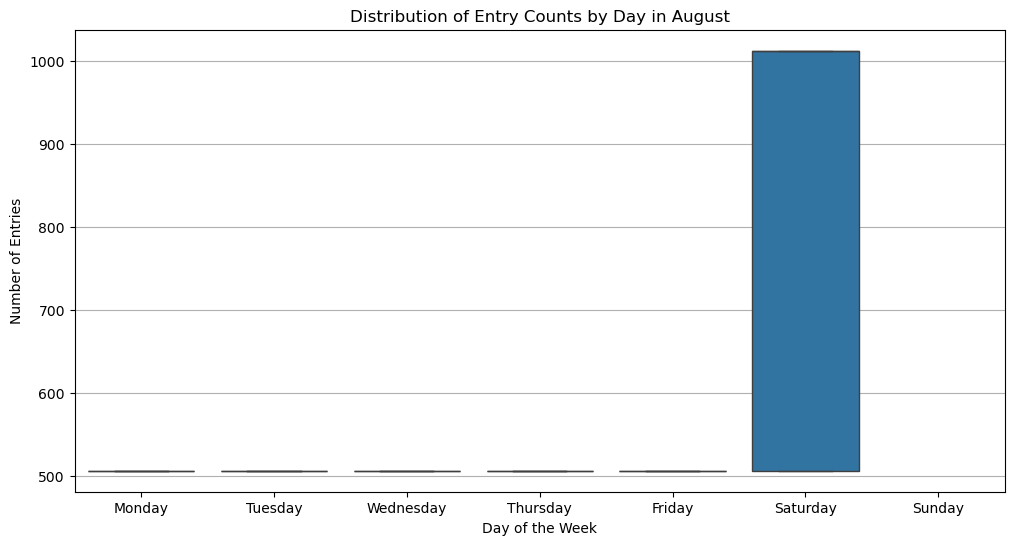

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='DayOfWeek', ylabel='UniqueHouseholds'>

Text(0.5, 1.0, 'Unique Households Reporting per Day in August')

Text(0, 0.5, 'Unique ANON_IDs')

Text(0.5, 0, 'Day of the Week')

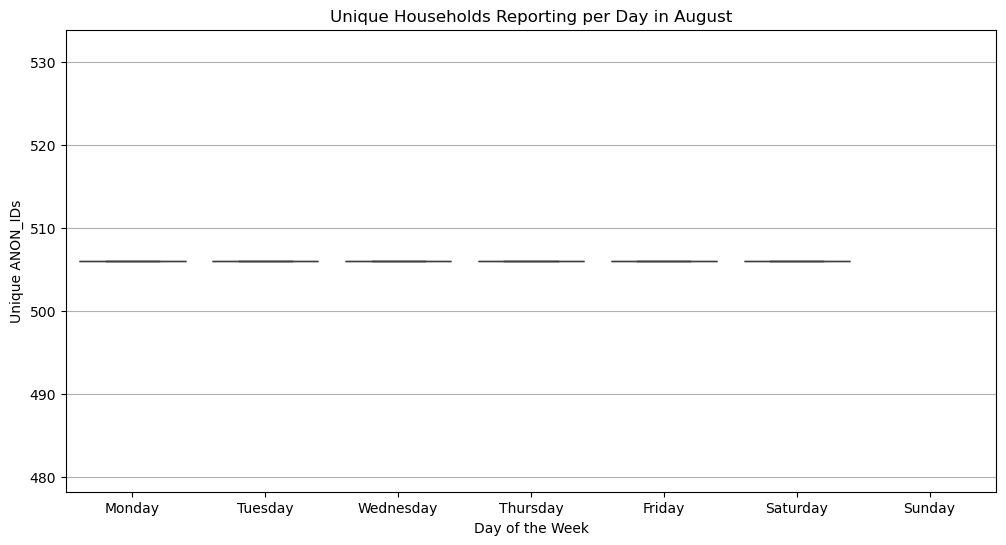

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for Month 8
df_august = df_control_Consolide_long[df_control_Consolide_long['Month'] == 8]

# Count entries per day in Month 8
entries_per_day = df_august.groupby(['Time', 'DayOfWeek']).size().reset_index(name='EntryCount')

# Count unique ANON_IDs per day
unique_ids_per_day = df_august.groupby(['Time', 'DayOfWeek'])['ANON_ID'].nunique().reset_index(name='UniqueHouseholds')

# Merge both counts into one DataFrame
day_analysis = entries_per_day.merge(unique_ids_per_day, on=['Time', 'DayOfWeek'])

print(day_analysis)

# Plot total entries per day in August
plt.figure(figsize=(12,6))
sns.boxplot(x="DayOfWeek", y="EntryCount", data=entries_per_day, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Distribution of Entry Counts by Day in August")
plt.ylabel("Number of Entries")
plt.xlabel("Day of the Week")
plt.grid(axis="y")
plt.show()

# Plot unique households per day in August
plt.figure(figsize=(12,6))
sns.boxplot(x="DayOfWeek", y="UniqueHouseholds", data=unique_ids_per_day, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Unique Households Reporting per Day in August")
plt.ylabel("Unique ANON_IDs")
plt.xlabel("Day of the Week")
plt.grid(axis="y")
plt.show()


In [132]:
# Create a unique identifier combining 'Time' and 'ANON_ID'
df_control_Consolide_long['Time_ANON_ID'] = df_control_Consolide_long['Time'].astype(str) + "_" + df_control_Consolide_long['ANON_ID'].astype(str)

# Filter for Saturdays in August
df_august_saturdays = df_control_Consolide_long[(df_control_Consolide_long['Month'] == 8) & (df_control_Consolide_long['DayOfWeek'] == 'Saturday')]

# Check for duplicate entries based on 'Time_ANON_ID'
duplicate_entries = df_august_saturdays[df_august_saturdays.duplicated(subset=['Time_ANON_ID'], keep=False)]

duplicate_entries


,Time,ANON_ID,ELEC_KWH,Month,DayOfWeek,HalfHour,Time_ANON_ID
5134,2024-08-03 00:00:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.014,8,Saturday,00:00,2024-08-03 00:00:00_8d606eeffaed80dba63c8b58b3...
5135,2024-08-03 00:00:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.014,8,Saturday,00:00,2024-08-03 00:00:00_8d606eeffaed80dba63c8b58b3...
5136,2024-08-03 00:30:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.040,8,Saturday,00:30,2024-08-03 00:30:00_8d606eeffaed80dba63c8b58b3...
5137,2024-08-03 00:30:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.040,8,Saturday,00:30,2024-08-03 00:30:00_8d606eeffaed80dba63c8b58b3...
5138,2024-08-03 01:00:00,8d606eeffaed80dba63c8b58b3c8c5268854bb561079c9...,0.033,8,Saturday,01:00,2024-08-03 01:00:00_8d606eeffaed80dba63c8b58b3...
...,...,...,...,...,...,...,...
5772995,2024-08-17 22:30:00,ccda3cf02d63eb6357954d94acc8aae83535124d286085...,NaN,8,Saturday,22:30,2024-08-17 22:30:00_ccda3cf02d63eb6357954d94ac...
5772996,2024-08-17 23:00:00,ccda3cf02d63eb6357954d94acc8aae83535124d286085...,NaN,8,Saturday,23:00,2024-08-17 23:00:00_ccda3cf02d63eb6357954d94ac...
5772997,2024-08-17 23:00:00,ccda3cf02d63eb6357954d94acc8aae83535124d286085...,NaN,8,Saturday,23:00,2024-08-17 23:00:00_ccda3cf02d63eb6357954d94ac...
5772998,2024-08-17 23:30:00,ccda3cf02d63eb6357954d94acc8aae83535124d286085...,NaN,8,Saturday,23:30,2024-08-17 23:30:00_ccda3cf02d63eb6357954d94ac...


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Month', ylabel='DayOfWeek'>

Text(0.5, 1.0, 'NaN Count in ELEC_KWH by Day of Week and Month')

Text(0.5, 36.72222222222221, 'Month')

Text(120.72222222222221, 0.5, 'Day of Week')

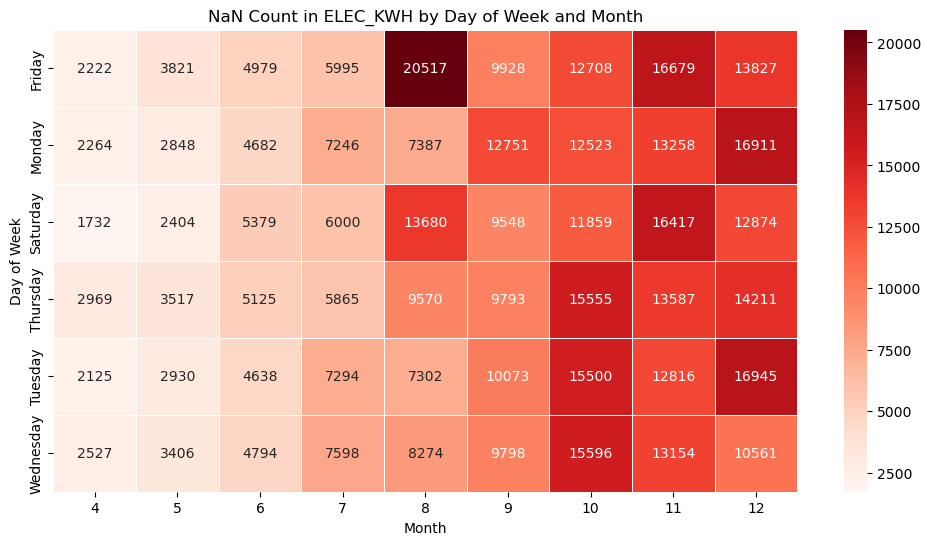

In [138]:
# Count NaN values per DayOfWeek and Month
nan_counts = df_control_Consolide_long.groupby(['Month', 'DayOfWeek'])['ELEC_KWH'].apply(lambda x: x.isna().sum()).reset_index()

# Rename columns for clarity
nan_counts.columns = ['Month', 'DayOfWeek', 'NaN_Count']

# Define the order of days for proper visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
nan_counts['DayOfWeek'] = pd.Categorical(nan_counts['DayOfWeek'], categories=day_order, ordered=True)

# Plot heatmap to visualize missing values per day and month
plt.figure(figsize=(12, 6))
pivot_nan = nan_counts.pivot(index='DayOfWeek', columns='Month', values='NaN_Count')
sns.heatmap(pivot_nan, annot=True, fmt=".0f", cmap="Reds", linewidths=0.5)

plt.title("NaN Count in ELEC_KWH by Day of Week and Month")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.show()



<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Month', ylabel='DayOfWeek'>

Text(0.5, 1.0, 'Percentage of ANON_IDs with at least 192 NaNs in ELEC_KWH by Day and Month')

Text(0.5, 36.72222222222221, 'Month')

Text(120.72222222222221, 0.5, 'Day of Week')

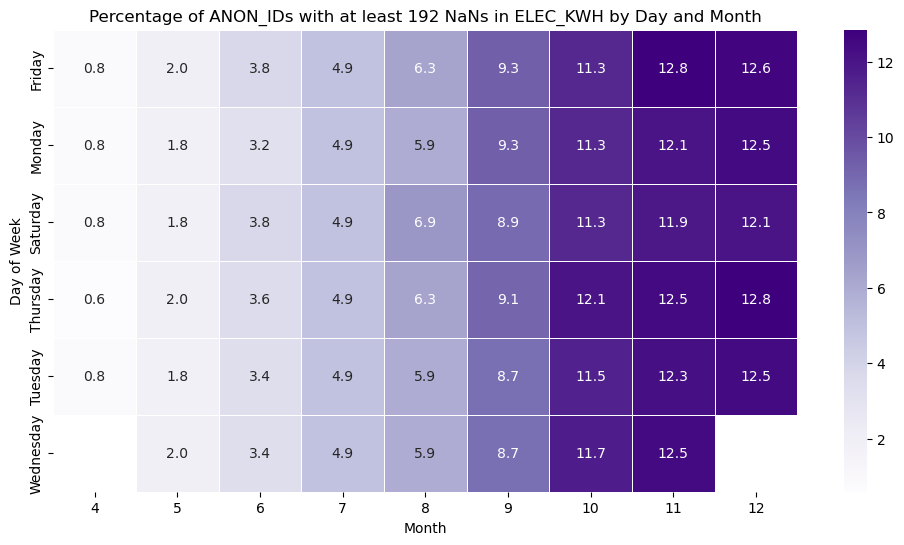

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count total ANON_IDs per DayOfWeek and Month
total_anon_counts = df_control_Consolide_long.groupby(['Month', 'DayOfWeek'])['ANON_ID'].nunique().reset_index()
total_anon_counts.columns = ['Month', 'DayOfWeek', 'Total_ANON_IDs']

# Count NaN values per ANON_ID, DayOfWeek, and Month
nan_counts_per_id = df_control_Consolide_long.groupby(['Month', 'DayOfWeek', 'ANON_ID'])['ELEC_KWH'].apply(lambda x: x.isna().sum()).reset_index()

# Rename columns for clarity
nan_counts_per_id.columns = ['Month', 'DayOfWeek', 'ANON_ID', 'NaN_Count']

# Filter to include only ANON_IDs with at least 10 NaNs
filtered_nan_counts = nan_counts_per_id[nan_counts_per_id['NaN_Count'] >= 192]

# Count how many unique ANON_IDs meet this condition per DayOfWeek and Month
anon_id_nan_summary = filtered_nan_counts.groupby(['Month', 'DayOfWeek'])['ANON_ID'].nunique().reset_index()
anon_id_nan_summary.columns = ['Month', 'DayOfWeek', 'Count_ANON_IDs']

# Merge with total ANON_IDs count to calculate the percentage
percentage_nan_summary = anon_id_nan_summary.merge(total_anon_counts, on=['Month', 'DayOfWeek'])
percentage_nan_summary['Percentage_ANON_IDs'] = (percentage_nan_summary['Count_ANON_IDs'] / percentage_nan_summary['Total_ANON_IDs']) * 100

# Define the order of days for proper visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
percentage_nan_summary['DayOfWeek'] = pd.Categorical(percentage_nan_summary['DayOfWeek'], categories=day_order, ordered=True)

# Plot heatmap to visualize the percentage of affected ANON_IDs
plt.figure(figsize=(12, 6))
pivot_anon_nan = percentage_nan_summary.pivot(index='DayOfWeek', columns='Month', values='Percentage_ANON_IDs')
sns.heatmap(pivot_anon_nan, annot=True, fmt=".1f", cmap="Purples", linewidths=0.5)

plt.title("Percentage of ANON_IDs with at least 192 NaNs in ELEC_KWH by Day and Month")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.show()


,Time,ANON_ID,ELEC_KWH,Month,DayOfWeek,HalfHour
0,2023-02-02 00:00:00,4dd3317694364b953434dc42eff7f9950095c4ab537c3b...,0.140,2,Thursday,00:00
1,2023-02-02 00:30:00,4dd3317694364b953434dc42eff7f9950095c4ab537c3b...,0.138,2,Thursday,00:30
2,2023-02-02 01:00:00,4dd3317694364b953434dc42eff7f9950095c4ab537c3b...,0.128,2,Thursday,01:00
3,2023-02-02 01:30:00,4dd3317694364b953434dc42eff7f9950095c4ab537c3b...,0.149,2,Thursday,01:30
4,2023-02-02 02:00:00,4dd3317694364b953434dc42eff7f9950095c4ab537c3b...,0.137,2,Thursday,02:00
...,...,...,...,...,...,...
5540475,2024-01-31 21:30:00,f60dba48cf44f787a3215d3c0f33eecdde790c1637ce01...,0.155,1,Wednesday,21:30
5540476,2024-01-31 22:00:00,f60dba48cf44f787a3215d3c0f33eecdde790c1637ce01...,0.116,1,Wednesday,22:00
5540477,2024-01-31 22:30:00,f60dba48cf44f787a3215d3c0f33eecdde790c1637ce01...,0.088,1,Wednesday,22:30
5540478,2024-01-31 23:00:00,f60dba48cf44f787a3215d3c0f33eecdde790c1637ce01...,0.086,1,Wednesday,23:00


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Month', ylabel='DayOfWeek'>

Text(0.5, 1.0, 'Percentage of ANON_IDs with at least 48 NaNs in ELEC_KWH by Day and Month')

Text(0.5, 36.72222222222221, 'Month')

Text(120.72222222222221, 0.5, 'Day of Week')

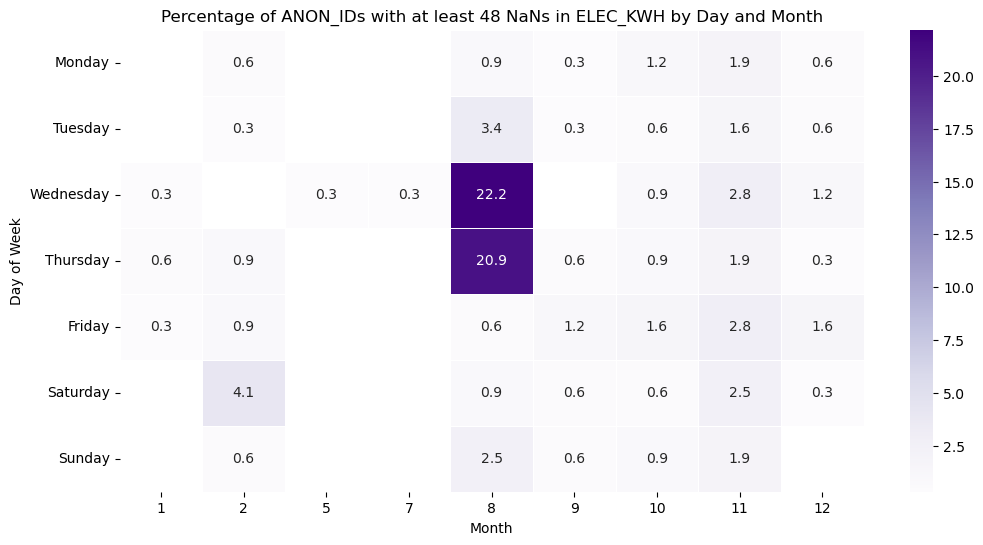

In [161]:
df_control_Consolide_Sunday_long
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count total ANON_IDs per DayOfWeek and Month
total_anon_counts = df_control_Consolide_Sunday_long.groupby(['Month', 'DayOfWeek'])['ANON_ID'].nunique().reset_index()
total_anon_counts.columns = ['Month', 'DayOfWeek', 'Total_ANON_IDs']

# Count NaN values per ANON_ID, DayOfWeek, and Month
nan_counts_per_id = df_control_Consolide_Sunday_long.groupby(['Month', 'DayOfWeek', 'ANON_ID'])['ELEC_KWH'].apply(lambda x: x.isna().sum()).reset_index()

# Rename columns for clarity
nan_counts_per_id.columns = ['Month', 'DayOfWeek', 'ANON_ID', 'NaN_Count']

# Filter to include only ANON_IDs with at least 10 NaNs
filtered_nan_counts = nan_counts_per_id[nan_counts_per_id['NaN_Count'] >= 48]

# Count how many unique ANON_IDs meet this condition per DayOfWeek and Month
anon_id_nan_summary = filtered_nan_counts.groupby(['Month', 'DayOfWeek'])['ANON_ID'].nunique().reset_index()
anon_id_nan_summary.columns = ['Month', 'DayOfWeek', 'Count_ANON_IDs']

# Merge with total ANON_IDs count to calculate the percentage
percentage_nan_summary = anon_id_nan_summary.merge(total_anon_counts, on=['Month', 'DayOfWeek'])
percentage_nan_summary['Percentage_ANON_IDs'] = (percentage_nan_summary['Count_ANON_IDs'] / percentage_nan_summary['Total_ANON_IDs']) * 100

# Define the order of days for proper visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
percentage_nan_summary['DayOfWeek'] = pd.Categorical(percentage_nan_summary['DayOfWeek'], categories=day_order, ordered=True)

# Plot heatmap to visualize the percentage of affected ANON_IDs
plt.figure(figsize=(12, 6))
pivot_anon_nan = percentage_nan_summary.pivot(index='DayOfWeek', columns='Month', values='Percentage_ANON_IDs')
sns.heatmap(pivot_anon_nan, annot=True, fmt=".1f", cmap="Purples", linewidths=0.5)

plt.title("Percentage of ANON_IDs with at least 48 NaNs in ELEC_KWH by Day and Month")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.show()


## SOCIO ECONOMIC


<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='AGE_GROUP'>

Text(0.5, 1.0, 'Distribution of AGE_GROUP (Ordered)')

Text(0.5, 0, 'AGE_GROUP')

Text(0, 0.5, 'Count')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '18-24'),
  Text(1, 0, '25-34'),
  Text(2, 0, '35-44'),
  Text(3, 0, '45-54'),
  Text(4, 0, '55-64'),
  Text(5, 0, '65-74'),
  Text(6, 0, '75+'),
  Text(7, 0, 'Unknown')])

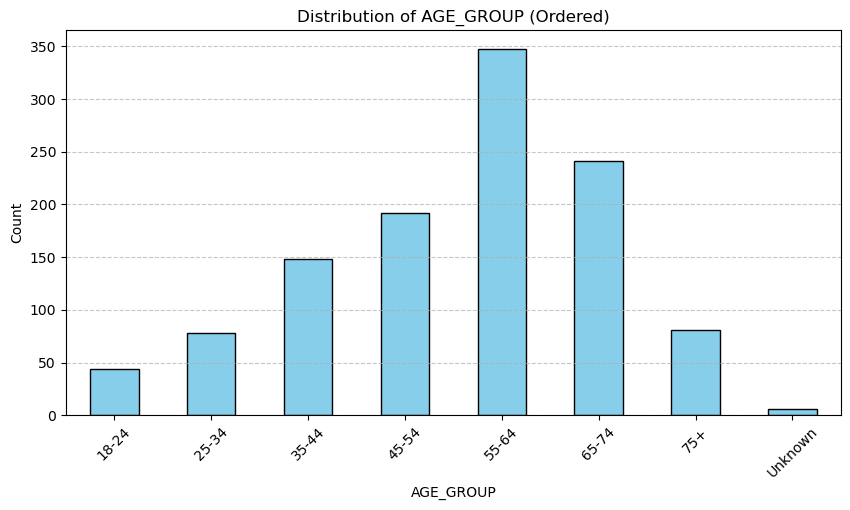

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='INCOME_CATEGORY'>

Text(0.5, 1.0, 'Distribution of INCOME_CATEGORY (Ordered)')

Text(0.5, 0, 'INCOME_CATEGORY')

Text(0, 0.5, 'Count')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '0-9,999'),
  Text(1, 0, '10,000-19,999'),
  Text(2, 0, '20,000-29,999'),
  Text(3, 0, '30,000-39,999'),
  Text(4, 0, '40,000-49,999'),
  Text(5, 0, '50,000-74,999'),
  Text(6, 0, '75,000-99,999'),
  Text(7, 0, '100,000+'),
  Text(8, 0, 'Unknown')])

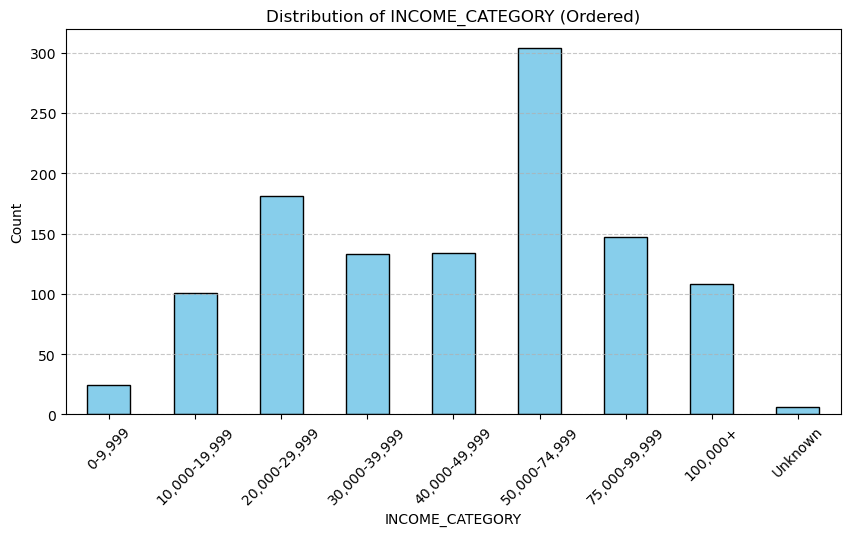

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='HOUSEHOLD_OCCUPANCY'>

Text(0.5, 1.0, 'Distribution of HOUSEHOLD_OCCUPANCY (Ordered)')

Text(0.5, 0, 'HOUSEHOLD_OCCUPANCY')

Text(0, 0.5, 'Count')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Single Adult Household'),
  Text(1, 0, 'Couple Household'),
  Text(2, 0, 'Multi-Occupancy Household'),
  Text(3, 0, 'Unknown')])

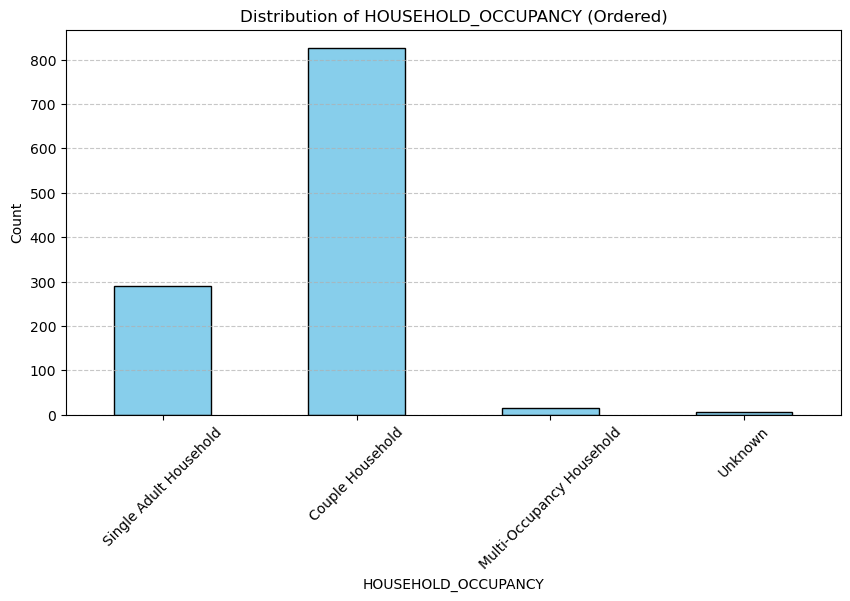

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='CHILDREN_AT_HOME'>

Text(0.5, 1.0, 'Distribution of CHILDREN_AT_HOME (Ordered)')

Text(0.5, 0, 'CHILDREN_AT_HOME')

Text(0, 0.5, 'Count')

(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2+'), Text(3, 0, 'Unknown')])

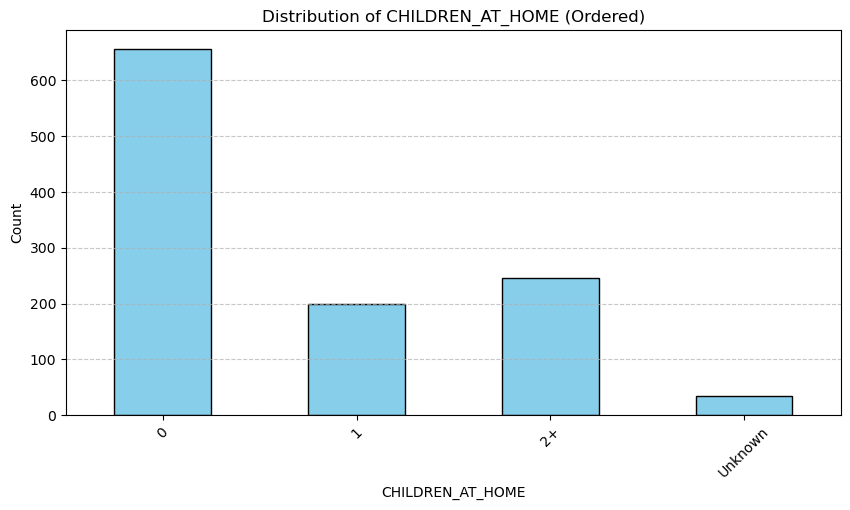

In [100]:
import matplotlib.pyplot as plt
import pandas as pd

# Define categorical and numerical features
categorical_features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP','HOME_VALUE'
]

numerical_features = [
    'ESTIMATED_CONSUMPTION_ELEC_DAY', 
    'ESTIMATED_CONSUMPTION_ELEC_NIGHT', 'ESTIMATED_CONSUMPTION_TOTAL'
]


# Define the correct order for each categorical feature
age_group_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+', 'Unknown']
income_category_order = ['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', 
                         '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+', 'Unknown']
household_occupancy_order = ['Single Adult Household', 'Couple Household', 
                             'Multi-Occupancy Household', 'Unknown']
children_at_home_order = ['0', '1', '2+', 'Unknown']

# Convert columns to categorical with defined order
df_socio['AGE_GROUP'] = pd.Categorical(df_socio['AGE_GROUP'], categories=age_group_order, ordered=True)
df_socio['INCOME_CATEGORY'] = pd.Categorical(df_socio['INCOME_CATEGORY'], categories=income_category_order, ordered=True)
df_socio['HOUSEHOLD_OCCUPANCY'] = pd.Categorical(df_socio['HOUSEHOLD_OCCUPANCY'], categories=household_occupancy_order, ordered=True)
df_socio['CHILDREN_AT_HOME'] = pd.Categorical(df_socio['CHILDREN_AT_HOME'], categories=children_at_home_order, ordered=True)

# List of features to plot
categorical_features = ['AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME']

# Plot sorted categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    df_socio[feature].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature} (Ordered)')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


<Figure size 1000x500 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of ESTIMATED_CONSUMPTION_ELEC_DAY')

Text(0.5, 0, 'ESTIMATED_CONSUMPTION_ELEC_DAY')

Text(0, 0.5, 'Frequency')

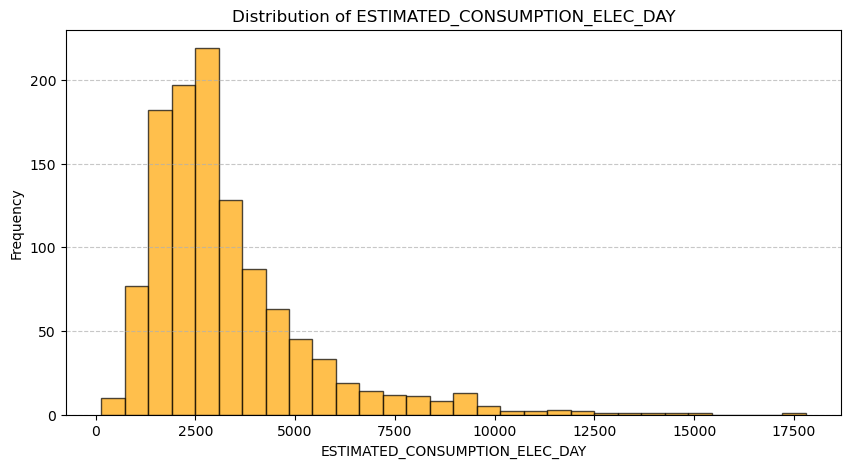

<Figure size 1000x500 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of ESTIMATED_CONSUMPTION_ELEC_NIGHT')

Text(0.5, 0, 'ESTIMATED_CONSUMPTION_ELEC_NIGHT')

Text(0, 0.5, 'Frequency')

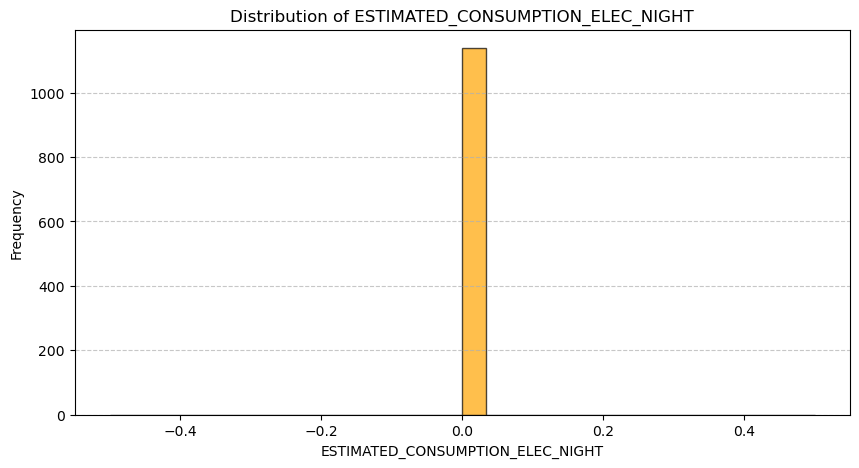

<Figure size 1000x500 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of ESTIMATED_CONSUMPTION_TOTAL')

Text(0.5, 0, 'ESTIMATED_CONSUMPTION_TOTAL')

Text(0, 0.5, 'Frequency')

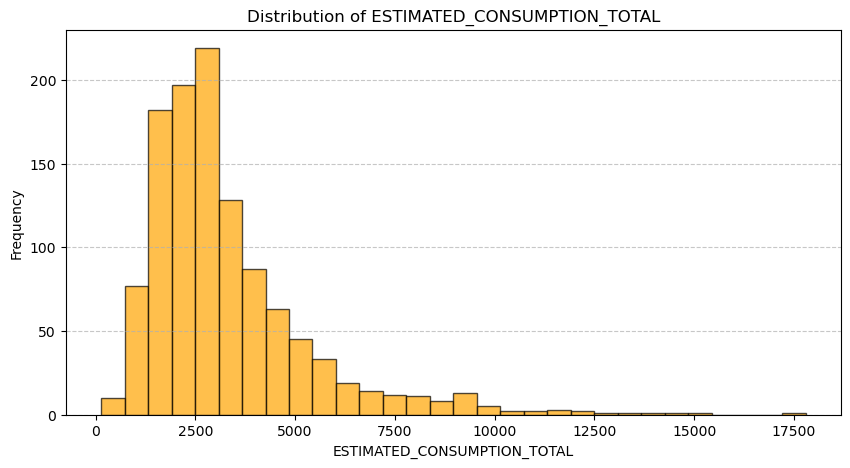

In [104]:


numerical_features = [
    'ESTIMATED_CONSUMPTION_ELEC_DAY', 
    'ESTIMATED_CONSUMPTION_ELEC_NIGHT', 'ESTIMATED_CONSUMPTION_TOTAL'
]
# Plot numerical features as histograms
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    df_socio[feature].plot(kind='hist', bins=30, color='orange', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap of Categorical Features (Encoded)')

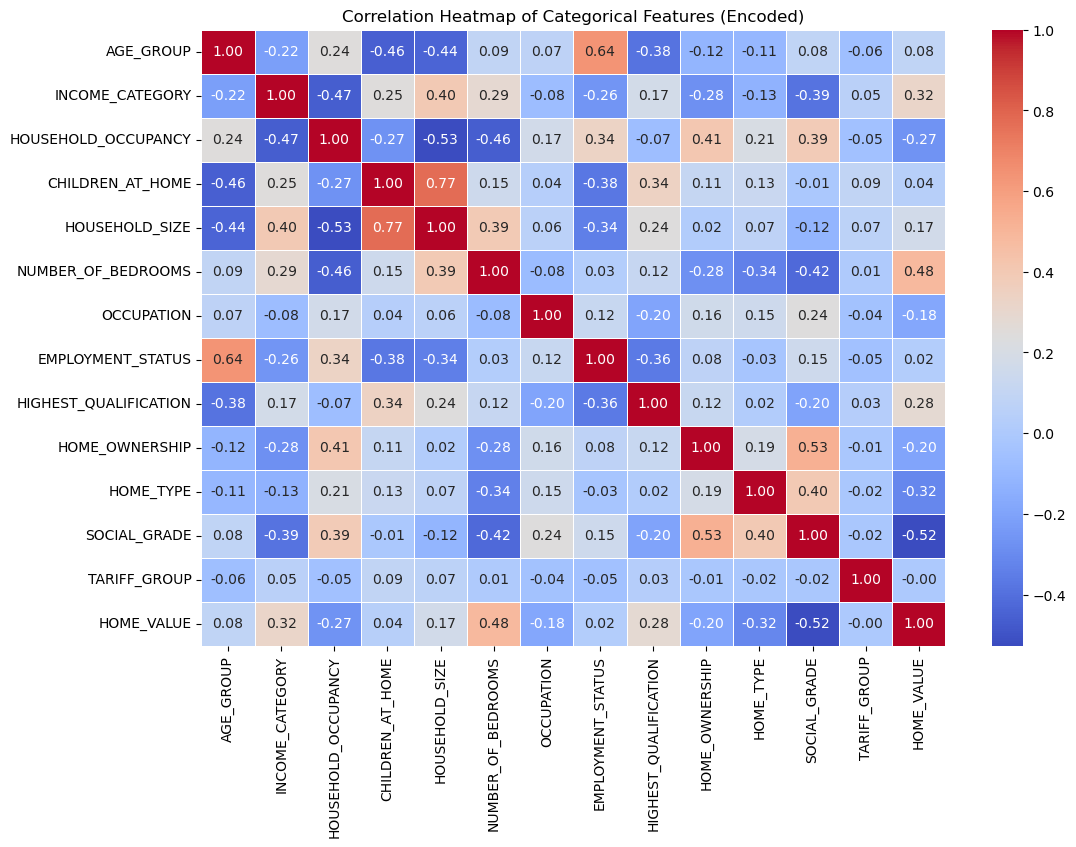

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# List of categorical features
categorical_features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP', 'HOME_VALUE'
]

# Create a copy of the dataframe to avoid modifying original data
df_encoded = df_socio[categorical_features].copy()

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))  # Convert to string to avoid issues with NaN
    label_encoders[col] = le

# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Categorical Features (Encoded)")
plt.show()


In [110]:
import pandas as pd

# List of features to check
features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP', 'HOME_VALUE'
]

# Count "Unknown" values per feature
unknown_counts = df_socio[features].apply(lambda x: (x == 'Unknown').sum())

# Calculate the percentage of "Unknown" values
unknown_percentage = (unknown_counts / len(df_socio)) * 100

# Create a summary DataFrame
unknown_summary = pd.DataFrame({
    'Feature': features,
    'Unknown_Count': unknown_counts.values,
    'Unknown_Percentage': unknown_percentage.values
})

unknown_summary


,Feature,Unknown_Count,Unknown_Percentage
0,AGE_GROUP,6,0.527241
1,INCOME_CATEGORY,6,0.527241
2,HOUSEHOLD_OCCUPANCY,6,0.527241
3,CHILDREN_AT_HOME,35,3.075571
4,HOUSEHOLD_SIZE,6,0.527241
5,NUMBER_OF_BEDROOMS,6,0.527241
6,OCCUPATION,6,0.527241
7,EMPLOYMENT_STATUS,6,0.527241
8,HIGHEST_QUALIFICATION,6,0.527241
9,HOME_OWNERSHIP,6,0.527241


In [114]:
unknown_age_hash_keys = df_socio.loc[df_socio['AGE_GROUP'] == 'Unknown', 'HASH_KEY']
unknown_age_hash_keys


107    da45e0a80966cd4b9f5ca6c0193a03398e28a307a4e833...
170    91f59759191ce53e5c8f8f8b7c4059f104cf411f703327...
388    315966d95c166a5ac4adb32f43c9efc7d83f6a329b1013...
431    bbb38d1299983f16aabe0478f0dce00ae21d3fe041ff3f...
615    f829e3ab557b14315c18052c22d9eb0239e0e6c3b6c4c8...
993    40f0ad90bfe9af640c81f9cb278c18c60df498f4f3eec2...
Name: HASH_KEY, dtype: object

In [116]:
unknown_age_hash_keys = df_socio.loc[df_socio['INCOME_CATEGORY'] == 'Unknown', 'HASH_KEY']
unknown_age_hash_keys

107    da45e0a80966cd4b9f5ca6c0193a03398e28a307a4e833...
170    91f59759191ce53e5c8f8f8b7c4059f104cf411f703327...
388    315966d95c166a5ac4adb32f43c9efc7d83f6a329b1013...
431    bbb38d1299983f16aabe0478f0dce00ae21d3fe041ff3f...
615    f829e3ab557b14315c18052c22d9eb0239e0e6c3b6c4c8...
993    40f0ad90bfe9af640c81f9cb278c18c60df498f4f3eec2...
Name: HASH_KEY, dtype: object

In [118]:
# Get all column names from df_control_Consolide
cols_control_consolide = set(df_control_Consolide.columns)

# Check which columns are NOT in df_socio['HASH_KEY']
missing_cols = cols_control_consolide - set(df_socio['HASH_KEY'])

print("Columns in df_control_Consolide that are NOT in df_socio['HASH_KEY']:")
print(missing_cols)


Columns in df_control_Consolide that are NOT in df_socio['HASH_KEY']:
{'cef4e134e06416be90396291d8a37128906c0bf249ef71d696a4f0b22d3cffde', 'f2abe7cbb5a60b61d874165fb6a1f0c7fcd4c33b8483759bc102ce4fbdf66365', '6dde0e5269f557dc5530f5107a9ad925b7fafc6a52d4f6fef834a0e23fd8b63c', '0a67e7537bf618ab4f6983665d02d2cba69773971926d22c411678814d730ff0', '31997152c8a481c326d6cb05abbd7690403eaf513945e1aba3279f31d344c956', 'a98f6c19e507bf7c07198b49919613e17465c9fffa59c6bc7ac0eeeb40ea217d', '5a1201e13a1fb54fdcd682525db62a20f48e9c30fa6377ecebd4773be01cab6e', 'ab48a3a3cca4eedbb8d6317c4e02de2523ecaa866117a0672aa989fa830ba52a', 'Time', 'e06665e30bb8bb901086cebe613ee5e64c2750c5b847281760cbf6754a75e66c', 'bbd37f115949e74f97d7fbb407e3ed505bc179507d744340dace2d71a5813950', '1e1bfa63fff199a44b7b248c11265dd721b33f1d2edc7e9fae9f714bbba78564', 'f2848aa492c813342866756de0da956026d4331e105b16f881357cae62dae2c1', '585675d4b905182ed7cee11a72597a682fbca36da153f6116fec806cf96ab0d5', '4ad2ed550310d9cf0c25d61b26241b9b93ac